# Load packages and import from SPSS file

In [119]:
import numpy as np
import pandas as pd
#import pyreadstat as prs
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector as SFS, RFECV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression #with built in CV for C and without 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC, VotingClassifier
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier as XGBC


#try halving gs to try to help with runtime 
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve
import shap

In [2]:
#SSPS filetype
filepath = "C:/Users/evalb/Box/Courses/BMI5111_Capstone/Data/Raw/"
filename = "SPSS_19Feb24_latest.sav"
    
print(filepath)

#could turn convert_categoricals=False to not convert cols into pd.categorical-but seems helpful
raw = pd.read_spss(filepath + filename)

#Expected: 30397 and 99
#Imported: (30397, 99) < match
print(raw.shape)

print(raw.head())

#convert all col names to lowercase for ease of coding
raw.columns = map(str.lower, raw.columns)


C:/Users/evalb/Box/Courses/BMI5111_Capstone/Data/Raw/
(30397, 99)
      Pt_ID  LatestAge  Gender Ethnicity7 Ethnicity4  Smoking  \
0  Z1000027       72.0  Female     Indian     Indian    Never   
1  Z1000396       79.0  Female    Chinese    Chinese  Passive   
2  Z1000636       92.0  Female    Chinese    Chinese    Never   
3  Z1001119       57.0  Female    Chinese    Chinese      Yes   
4  Z1001525       77.0  Female    Chinese    Chinese    Never   

           Smoking3     MeanSBP    MeanDBP  MinSBP  ...  \
0             Never  133.500000  65.500000   130.0  ...   
1  Yes, Ex, Passive  128.000000  63.600000   124.0  ...   
2             Never         NaN        NaN     NaN  ...   
3  Yes, Ex, Passive  139.608696  79.782609   130.0  ...   
4             Never  142.200000  68.800000   127.0  ...   

   RAASi_percentdosechange_2cat  RAASi_Vlast_maxdosevsnil  Tertiarycare_added  \
0              Same or Increase              Dose >/=100%                 0.0   
1              Same or Inc

# Subset to my study population

In [3]:
# 1.Patients with CKD and aged 21 and older (already required to be in this dataset)

# 2.Patients who have been prescribed renal-protective drugs. 
    #Operationalized as: any patient with a ‘Y’ in the following columns: raasi, nsmra, smra, sglt2i, metformin
    #ignore  "statins", "esas" for anemia 
    
print(raw.shape)

drug_flag_cols = ["raasi", "nsmra", "smra", "sglt2i", "metformin"]    

raw['combine_drug_cols'] = raw[drug_flag_cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
#looks good: print(raw['combine_drug_cols'].value_counts(normalize=True))

raw["has_renalprot_drug"] = [0 if x == "NNNNN" else 1 for x in raw['combine_drug_cols']]
#looks good: print(pd.crosstab(raw['combine_drug_cols'], raw["has_renalprot_drug"],normalize=True))

#expecting 29% of rows to drop here
raw = raw[raw["has_renalprot_drug"] == 1]
raw = raw.drop(columns=['combine_drug_cols', "has_renalprot_drug"])
print(raw.shape)


(30397, 99)
(21492, 99)


In [4]:
#ADDL REQUIREMENTS RELATED TO SCR - multiple measurements

#if patient doesn't have cr mean, cr v1, and cr vlast, must drop because can't do the full outcome
raw = raw.query('cr_vlast > 0 & cr_mean > 0 & cr_vlast > 0')
print(raw.shape)

#should remove patients with only one SCr value b/c I cannot evaluate if they have AKI
    #note: this will only shrink the non-outcome class (outcome class has differing values by definition) 
    #confirm with PI - DONE
    
raw = raw.query('~(cr_mean == cr_v1 | cr_mean == cr_vlast)')
print(raw.shape)


(17504, 99)
(11116, 99)


In [5]:
#ADDL REQUIREMENTS RELATED TO SCR - remove very healthy patients 
raw = raw[raw["cr_mean"] >= 100]

print(raw.shape)

(8722, 99)


# Quick Cleanup

In [6]:
#pad no.admits, adm_days with 0's (currently treated as missing values) 
    
raw["ip_count"] = [x if x>0 else 0 for x in raw["no.admits"]]
raw["ip_days"] = [x if x>0 else 0 for x in raw["adm_days"]]

#print(raw["no.admits"].describe())
#print(raw["ip_count"].describe())
#print(raw["no.admits"].describe())
#print(raw["ip_count"].describe())              

In [7]:
#drop ip count b/c of correlation with ip days but make a dummy for high amounts

raw["ip_count_many"] = ["overequal5" if x >= 5 else "lt5" for x in raw["ip_count"]]



In [8]:
#flip 17% null/not asked in smoking to no (like mode imputation) 

raw["smoking"] = ["Y" if x == "Yes, Ex, Passive" else "N" for x in raw["smoking3"]]
#print(raw["smoking3"].value_counts(normalize=True))
#print(raw["smoking"].value_counts(normalize=True))

In [9]:
#Fix Statins to match all the other drug cols (Y/N instead of (1/2)

#print(raw["statins"].value_counts(normalize=True))
raw["statins"] = ["Y" if x == "1" else "N" for x in raw["statins"]]
raw["statins"] = raw["statins"].astype("category")

#make it a category to make


#print(raw["statins"].value_counts(normalize=True))

In [10]:
#Per PI, the 0 here is missing, not actually a 0. recode as missing so it can go through imputation
    #this aligns with uACR_mean_yesno

#print(raw["uacr_mean"].describe())

raw["uacr_mean"] = [x if x>0 else np.NAN for x in raw["uacr_mean"]]
                    
#print(raw["uacr_mean"].describe())

In [11]:
#Flip 10% unknown in raasi % max dose last cateogry to 50-99% (like mode imputation) 

#print(raw["raasi_percentmaxdose_vlast_category"].value_counts(normalize=True))
raw["raasi_percentmaxdose_vlast_category"] = ["50-99%" if x == "Nil" else x for x in raw["raasi_percentmaxdose_vlast_category"]]
#print(raw["raasi_percentmaxdose_vlast_category"].value_counts(normalize=True))

In [12]:
#figure out if egfrdecline is between v1 and vlast 
#confirmed: it's actually the the PERCENT change from first to last
#so let's keep mean, last, and decline

#print(raw[["egfr_v1", "egfr_mean", "egfr_vlast", "egfrdecline"]].head(10))

In [13]:
#columns to drop per PI (due to unreliability or unknown construction), totally empty, redundant/high collinear, etc
    #iterative!

raw_cols_to_drop = [
    'meanbmi', 'tertiarycare_added', 'primarycare_added', 'tertiarycare_any', 'primarycare_any',  
    'ter_or_pricare',  'ter_andor_pricare', 'latest_e', 'latest_f', 'latest_g', 'latest_h',
    'raasi_status', 'smoking', 'ethnicity7',
    "no.admits", "adm_days", "smoking3", #created new cleaned versions above 
    "raasi_date_v1", "raasi_date_vlast",     #coming in incorrectly due to ssps to python conversion
    "pt_id",     #useful for checking no dups but now ready to drop to avoid it being used in feature selection
    "raasi_totaldose_v1", "raasi_totaldose_vlast", #if I find predictive power in higher level RAASi dose/brand columns, can reintroduce these
    "raasi_vlast_maxdosevsnil",   #removed related to FS checks including collinearity / redundnacy
    "ip_count", "meansbp_less110",
    "potassium_max_greater5.0", "potassium_max_greater5.5", #have max itself showing predictive power, this is not 
    "raasi_percentdosechange_2cat",
    
    #dump related to outcome:
    "egfr_vlast", "egfrdecline", 
    
    "kfre_egfr", #redundant and colinear to egfr_decline and egfr_last
    "kfre_age",  "kfre_gen", "kfre_uacr_mgmmol", "uacr_mean_yesno",    #redundant #leave in: "kfre_uacr_mgg",
    "kfre_uacr_mgg", "diab_n_uacr", 
    "diabetes_incl_hba1c",  "diabetes_incl_hba1c_n_uacr",
    
    #redundant if I let egfr_mean and cr_mean back in 
    "egfr_mean_catless30", "egfr_mean_catless45",
    
    #drop due to multicollinearity identified in VIF
    "raasi_percentmaxdose_v1", "potassium_min", "raasi_totaldosemg_vlast", "meandbp", "meansbp", "raasi_percentdosechange_category"
    
    ]   
   
raw.drop(raw_cols_to_drop, axis=1, inplace=True)

### Drop cols with large amount of missing values

In [14]:
#FIRST, create calcium feature

#while calcium isn't often measured, flag if too high or two low (there for about 10% of data)
    #https://onlinelibrary.wiley.com/doi/10.1111/ijcp.13057#:~:text=Both%20unadjusted%20and%20adjusted%20analyses,1.91)%20in%20patients%20with%20admission
    #might not be community-acquired specific, but still try
    #found NUS ranges: https://nuhsingapore.testcatalog.org/show/CA: for age 18 and above: 2.10  – 2.60 mmol/L
    
#this will also code the missing ones as fine, which I think makes sense given the options
raw["calcium_levels_good"] = ["N" if x < 2.10 or x > 2.6 else "Y" for x in raw["calcium_mean"]]
    
print(raw["calcium_mean"].groupby(raw["calcium_levels_good"]).describe())
print(raw["calcium_levels_good"].value_counts())


                      count      mean       std   min   25%   50%    75%   max
calcium_levels_good                                                           
N                     106.0  2.191322  0.323466  1.23  2.00  2.07  2.610  2.83
Y                    1384.0  2.338502  0.106850  2.10  2.26  2.34  2.415  2.60
Y    8616
N     106
Name: calcium_levels_good, dtype: int64


In [15]:
# And a phosphate feature
    #https://nuhsingapore.testcatalog.org/show/PO4
    #20+ years: 0.75-1.50 mmol/L

#this will also code the missing ones as fine, which I think makes sense given the options
raw["phos_levels_good"] = ["N" if x < 0.75 or x > 1.5 else "Y" for x in raw["phos_mean"]]
    
print(raw["phos_mean"].groupby(raw["phos_levels_good"]).describe())
print(raw["phos_levels_good"].value_counts())


                   count      mean       std   min   25%       50%   75%   max
phos_levels_good                                                              
N                  111.0  1.647938  0.374743  0.66  1.54  1.601429  1.76  3.14
Y                 1116.0  1.184464  0.154355  0.75  1.08  1.190000  1.29  1.50
Y    8611
N     111
Name: phos_levels_good, dtype: int64


In [16]:
#drop columns with large amounts of missing values 

missing_threshold = len(raw)*0.40
print(f"missing threshold: {missing_threshold}")

cols_over_threshold = raw.columns[raw.isna().sum() <= missing_threshold]

print(f"cols over threshold: {len(cols_over_threshold)}")

print(raw.shape)

raw = raw[cols_over_threshold]

print(raw.shape)


missing threshold: 3488.8
cols over threshold: 49
(8722, 57)
(8722, 49)


# Feature Creation

In [17]:
#only 2%
'''
print(raw["esas_Y"].value_counts(normalize=True))

#much more common in aki cohort than rest of patients - try including even if not picked up in FS
print(round(pd.crosstab(raw["esas_Y"] ,raw["aki_proxy"],),3))
'''

'\nprint(raw["esas_Y"].value_counts(normalize=True))\n\n#much more common in aki cohort than rest of patients - try including even if not picked up in FS\nprint(round(pd.crosstab(raw["esas_Y"] ,raw["aki_proxy"],),3))\n'

In [18]:
#ip count and age interation. Lee had 75+ bucket
#prep for interaction

raw["age_ge75"] = ["Y" if x >= 75 else "N" for x in raw["latestage"]]

print(raw["latestage"].groupby(raw["age_ge75"]).describe())


           count       mean       std   min   25%   50%   75%    max
age_ge75                                                            
N         4994.0  65.663396  7.662116  23.0  62.0  68.0  71.0   74.0
Y         3728.0  81.073498  4.907348  75.0  77.0  80.0  84.0  102.0


In [19]:
print(raw.columns)

Index(['latestage', 'gender', 'ethnicity4', 'minsbp', 'mindbp', 'maxsbp',
       'maxdbp', 'visits_nuh', 'visits_ah', 'visits_ntfgh', 'visits_bbk_ops',
       'visits_bp_ops', 'visits_cck_ops', 'visits_clem_ops', 'visits_jur_ops',
       'visits_pioneer_ops', 'visits_qt_ops', 'no_of_visits', 'diabetes',
       'heart_dz', 'stroke', 'pvd', 'aki_ever', 'raasi', 'nsmra', 'smra',
       'sglt2i', 'metformin', 'statins', 'esas', 'hba1c_mean',
       'potassium_mean', 'potassium_max', 'egfr_mean', 'egfr_v1', 'cr_mean',
       'cr_v1', 'cr_vlast', 'uacr_mean', 'sodium_mean', 'kfresea_5yrs',
       'raasi_totaldosemg_v1', 'raasi_percentmaxdose_vlast',
       'raasi_percentmaxdose_vlast_category', 'raasi_percentdosechange',
       'ip_days', 'ip_count_many', 'calcium_levels_good', 'phos_levels_good',
       'age_ge75'],
      dtype='object')


In [20]:
#try adding missing sodium, missing potassium similar to Murphy et al 
raw["sodium_missing"] = ["not missing" if x > 0 else "missing" for x in raw["sodium_mean"]]

raw["potassium_missing"] = ["not missing" if x > 0 else "missing" for x in raw["potassium_mean"]]

print(raw["sodium_missing"].value_counts())
print(raw["potassium_missing"].value_counts())


not missing    8355
missing         367
Name: sodium_missing, dtype: int64
not missing    6927
missing        1795
Name: potassium_missing, dtype: int64


In [21]:
#egfr decline but from first to mean rather than mean to last, which is info leakage

raw["egfr_pct_change_first_mean"] = (raw["egfr_mean"] - raw["egfr_v1"])/raw["egfr_v1"]

print(raw["egfr_pct_change_first_mean"].describe())

count    8710.000000
mean       -0.008417
std         0.105453
min        -0.643478
25%        -0.066667
50%        -0.013889
75%         0.043103
max         1.223529
Name: egfr_pct_change_first_mean, dtype: float64


In [22]:
#same for Cr

raw["cr_pct_change_first_mean"] = (raw["cr_mean"] - raw["cr_v1"])/raw["cr_v1"]

print(raw["cr_pct_change_first_mean"].describe())

count    8722.000000
mean        0.024687
std         0.122678
min        -0.337302
25%        -0.037710
50%         0.009901
75%         0.060870
max         3.286822
Name: cr_pct_change_first_mean, dtype: float64


In [23]:
#Drug combos: first, pick out the most common combo: sglt2i and metformin

raw['temp_sglt2i_metformin'] = raw[["sglt2i","metformin"]].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
raw["sglt2i_metformin"] = ["both" if x == "YY" else "not both" for x in raw["temp_sglt2i_metformin"]]

print(raw['temp_sglt2i_metformin'].value_counts())
print(raw['sglt2i_metformin'].value_counts())

NN    3914
YY    2029
NY    1848
YN     931
Name: temp_sglt2i_metformin, dtype: int64
not both    6693
both        2029
Name: sglt2i_metformin, dtype: int64


In [24]:
#Drug combos: next, flag if on 3 or more renal-protective drugs
raw['combine_drug_cols2'] = (raw[drug_flag_cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1))
raw['combine_drug_cols2'] = raw['combine_drug_cols2'].str.replace('N','')

print(raw['combine_drug_cols2'].value_counts()) #normalize=True

raw["ge3_renalprot_drugs"] = ["Y" if len(x) >= 3 else "N" for x in raw["combine_drug_cols2"]]

print(raw["ge3_renalprot_drugs"].value_counts())

Y       4244
YY      2478
YYY     1823
YYYY     177
Name: combine_drug_cols2, dtype: int64
N    6722
Y    2000
Name: ge3_renalprot_drugs, dtype: int64


In [25]:
#because most patients have visits at only or mostly one outpatient clinic, I'm getting multicollinearity on those features
#I want to keep TOTAL op visits, so instead repurpose these to 1 if >0 visits in that area and 0 otherwise
#these new features will be a proxy for where the patient lives, which could carry SES patterns

raw["dummy"] = 1

#hospital
raw["has_visits_nuh"] = raw[["visits_nuh", "dummy"]].min(axis=1)
raw["has_visits_ah"] = raw[["visits_ah", "dummy"]].min(axis=1)
raw["has_visits_ntfgh"] = raw[["visits_ntfgh", "dummy"]].min(axis=1)

#outpatient
raw["has_visits_bbk_ops"] = raw[["visits_bbk_ops", "dummy"]].min(axis=1)
raw["has_visits_bp_ops"] = raw[["visits_bp_ops", "dummy"]].min(axis=1)
raw["has_visits_cck_ops"] = raw[["visits_cck_ops", "dummy"]].min(axis=1)
raw["has_visits_clem_ops"] = raw[["visits_clem_ops", "dummy"]].min(axis=1)
raw["has_visits_jur_ops"] = raw[["visits_jur_ops", "dummy"]].min(axis=1)
raw["has_visits_pioneer_ops"] = raw[["visits_pioneer_ops", "dummy"]].min(axis=1)
raw["has_visits_qt_ops"] = raw[["visits_qt_ops", "dummy"]].min(axis=1)

print(raw["visits_qt_ops"].groupby(raw["has_visits_qt_ops"]).describe())


                    count       mean        std  min   25%   50%   75%   max
has_visits_qt_ops                                                           
0.0                8076.0   0.000000   0.000000  0.0   0.0   0.0   0.0   0.0
1.0                 646.0  27.052632  11.250096  1.0  19.0  27.0  34.0  78.0


### Addl features to drop

In [26]:
#drop ones I had to use to create others, meaning I couldn't drop them earlier
raw = raw.drop(columns=['temp_sglt2i_metformin', "combine_drug_cols2", "cr_v1", "egfr_v1", "potassium_mean", "sodium_mean",
                       "visits_nuh", "visits_ah", "visits_ntfgh", "visits_bbk_ops", "visits_bp_ops", "visits_cck_ops", "visits_clem_ops",
                        "visits_jur_ops", "visits_pioneer_ops", "visits_qt_ops"])

### Create dummy columns for the flags 

In [27]:
#print(raw.info(verbose=True))

#confirm data types look good 
raw_cat_cols = raw.select_dtypes("category").columns
raw_obj_cols = raw.select_dtypes("object").columns
raw_num_cols = raw.select_dtypes(exclude=["category","object"]).columns

'''
for c in raw_cat_cols:
    print(c)
    print(raw[c].value_counts(normalize=True))

for c in raw_num_cols:
    print(c)
    print(raw[c].describe())
'''


'\nfor c in raw_cat_cols:\n    print(c)\n    print(raw[c].value_counts(normalize=True))\n\nfor c in raw_num_cols:\n    print(c)\n    print(raw[c].describe())\n'

In [28]:
#store the original version
raw_predummies = raw.copy(deep=True)

print(raw_cat_cols)
print(raw_obj_cols)
raw_nonnum_cols = raw_cat_cols.append(raw_obj_cols)

#drop_first=True will give us our reference class: 
raw = pd.get_dummies(data=raw, columns=raw_nonnum_cols, drop_first=True)


Index(['gender', 'ethnicity4', 'diabetes', 'heart_dz', 'stroke', 'pvd',
       'aki_ever', 'raasi', 'nsmra', 'smra', 'sglt2i', 'metformin', 'statins',
       'esas'],
      dtype='object')
Index(['raasi_percentmaxdose_vlast_category', 'ip_count_many',
       'calcium_levels_good', 'phos_levels_good', 'age_ge75', 'sodium_missing',
       'potassium_missing', 'sglt2i_metformin', 'ge3_renalprot_drugs'],
      dtype='object')


In [29]:
print(raw.columns)

Index(['latestage', 'minsbp', 'mindbp', 'maxsbp', 'maxdbp', 'no_of_visits',
       'hba1c_mean', 'potassium_max', 'egfr_mean', 'cr_mean', 'cr_vlast',
       'uacr_mean', 'kfresea_5yrs', 'raasi_totaldosemg_v1',
       'raasi_percentmaxdose_vlast', 'raasi_percentdosechange', 'ip_days',
       'egfr_pct_change_first_mean', 'cr_pct_change_first_mean', 'dummy',
       'has_visits_nuh', 'has_visits_ah', 'has_visits_ntfgh',
       'has_visits_bbk_ops', 'has_visits_bp_ops', 'has_visits_cck_ops',
       'has_visits_clem_ops', 'has_visits_jur_ops', 'has_visits_pioneer_ops',
       'has_visits_qt_ops', 'gender_Male', 'ethnicity4_Indian',
       'ethnicity4_Malay', 'ethnicity4_Others', 'diabetes_Y', 'heart_dz_Y',
       'stroke_Y', 'pvd_Y', 'aki_ever_Y', 'raasi_Y', 'nsmra_Y', 'smra_Y',
       'sglt2i_Y', 'metformin_Y', 'statins_Y', 'esas_Y',
       'raasi_percentmaxdose_vlast_category_50-99%',
       'ip_count_many_overequal5', 'calcium_levels_good_Y',
       'phos_levels_good_Y', 'age_ge75_Y', 's

In [30]:
#clean up column names to be more intuitive

raw = raw.rename(columns={'meansbp_less110_>/=110': 'meansbp_ge110',
                    'egfr_mean_catless30_>/=30': 'egfr_mean_ge30',
                    'egfr_mean_catless45_>/=45': 'egfr_mean_ge45',
                    'uacr_mean_yesno_>/=3mg‎/mmol': 'uacr_mean_ge3mg_mmol',
                    'raasi_percentdosechange_2cat_Same or Increase': 'raasi_percentdosechange_same_inc', 
                    'raasi_vlast_maxdosevsnil_Dose<100%': 'raasi_vlast_maxdosevsnil_lt100percent', 
                    'diab_n_uacr_DM + uACR>/=3': 'diab_n_uacr_dm_uacrge3',
                    'diab_n_uacr_no DM + uACR<3': 'diab_n_uacr_nodm_uacrlt3', 
                    'diab_n_uacr_no DM + uACR>/=3': 'diab_n_uacr_nodm_uacrge3',
                    'diabetes_incl_hba1c_n_uacr_DM + uACR>/=3': 'diabetes_incl_hba1c_n_uacr_dm_uacrge3',
                    'diabetes_incl_hba1c_n_uacr_no DM + uACR<3': 'diabetes_incl_hba1c_n_uacr_nodm_uacrlt3',
                    'diabetes_incl_hba1c_n_uacr_no DM + uACR>/=3': 'diabetes_incl_hba1c_n_uacr_nodm_uacrge3',
                    'raasi_percentmaxdose_vlast_category_50-99%': 'raasi_percentmaxdose_vlast_50_99percent',
                    'ip_count_many_overequal5': 'ip_count_ge5',
                    "age_ge75_Y": "age_ge75",
                    'sodium_missing_not missing': 'sodium_missing',
                    'potassium_missing_not missing': 'potassium_missing',
                    'calcium_levels_good_Y':"calcium_levels_normal",
                    'phos_levels_good_Y': 'phos_levels_normal',
                    'potassium_max_greater5.5_K >5.5': 'potassium_max_gt_5p5k',
                    'raasi_percentdosechange_category_Increase': 'raasi_percentdosechange_category_increase',
                    'raasi_percentdosechange_category_Same': 'raasi_percentdosechange_category_same',
                    'sglt2i_metformin_not both': 'not_both_sglt2i_metformin',
                    'ge3_renalprot_drugs_Y': 'ge3_renalprot_drugs'
        })

    
print(raw.columns)

Index(['latestage', 'minsbp', 'mindbp', 'maxsbp', 'maxdbp', 'no_of_visits',
       'hba1c_mean', 'potassium_max', 'egfr_mean', 'cr_mean', 'cr_vlast',
       'uacr_mean', 'kfresea_5yrs', 'raasi_totaldosemg_v1',
       'raasi_percentmaxdose_vlast', 'raasi_percentdosechange', 'ip_days',
       'egfr_pct_change_first_mean', 'cr_pct_change_first_mean', 'dummy',
       'has_visits_nuh', 'has_visits_ah', 'has_visits_ntfgh',
       'has_visits_bbk_ops', 'has_visits_bp_ops', 'has_visits_cck_ops',
       'has_visits_clem_ops', 'has_visits_jur_ops', 'has_visits_pioneer_ops',
       'has_visits_qt_ops', 'gender_Male', 'ethnicity4_Indian',
       'ethnicity4_Malay', 'ethnicity4_Others', 'diabetes_Y', 'heart_dz_Y',
       'stroke_Y', 'pvd_Y', 'aki_ever_Y', 'raasi_Y', 'nsmra_Y', 'smra_Y',
       'sglt2i_Y', 'metformin_Y', 'statins_Y', 'esas_Y',
       'raasi_percentmaxdose_vlast_50_99percent', 'ip_count_ge5',
       'calcium_levels_normal', 'phos_levels_normal', 'age_ge75',
       'sodium_missing', '

In [31]:
#age ge 75 and high hospital count interaction

raw['age_ge75_ipcount_ge5'] = raw.apply(lambda row: (row['age_ge75']*row['ip_count_ge5']
                                                    ),
                                   axis=1)

'''
print(raw["age_ge75_ipcount_ge5"].groupby(raw["age_ge75"]).describe())
print(raw["age_ge75_ipcount_ge5"].groupby(raw["ip_count_ge5"]).describe())
print(pd.crosstab(raw["age_ge75"], raw["ip_count_ge5"]))
print(raw["age_ge75_ipcount_ge5"].value_counts())
'''

'\nprint(raw["age_ge75_ipcount_ge5"].groupby(raw["age_ge75"]).describe())\nprint(raw["age_ge75_ipcount_ge5"].groupby(raw["ip_count_ge5"]).describe())\nprint(pd.crosstab(raw["age_ge75"], raw["ip_count_ge5"]))\nprint(raw["age_ge75_ipcount_ge5"].value_counts())\n'

# Define the AKI Outcome Variable

In [32]:
raw["cr_pct_change"] = (raw["cr_vlast"] - raw["cr_mean"])/raw["cr_mean"]

print(raw[["cr_mean", "cr_vlast", "cr_pct_change"]].head(15))

#mean vs last: IQR is -1.6% and then +1.8%
#mean vs first: IQR is -2.0% and then +1.5%
print(raw["cr_pct_change"].describe())

    cr_mean  cr_vlast  cr_pct_change
1     105.0     107.0       0.019048
5     104.0     108.0       0.038462
11    125.0     132.0       0.056000
14    448.0     546.0       0.218750
18    241.0     290.0       0.203320
20    135.0     139.0       0.029630
21    118.0     114.0      -0.033898
33    139.0     155.0       0.115108
36    125.0     111.0      -0.112000
37    117.0     102.0      -0.128205
39    168.0     175.0       0.041667
41    106.0      97.0      -0.084906
47    104.0     107.0       0.028846
49    118.0     107.0      -0.093220
52    334.0     380.0       0.137725
count    8722.000000
mean        0.013230
std         0.100715
min        -0.431138
25%        -0.040323
50%         0.007937
75%         0.051724
max         1.379464
Name: cr_pct_change, dtype: float64


In [33]:
#50% is only 47 rows
#30% is 162 rows - still super small for splitting into train and test. PI ok'd this 

threshold = 0.3
print((raw["cr_pct_change"] > threshold).sum())

raw["aki_proxy"] = [1 if x > threshold else 0 for x in raw["cr_pct_change"]]

print(raw["aki_proxy"].value_counts())
print(raw["aki_proxy"].value_counts(normalize=True)) #1.3%


136
0    8586
1     136
Name: aki_proxy, dtype: int64
0    0.984407
1    0.015593
Name: aki_proxy, dtype: float64


In [34]:
#Outliers? Update: see her text confirming which amounts are fine 

print(raw[["cr_mean", "cr_vlast"]][raw["aki_proxy"] == 1].describe())

#print(raw[["cr_mean", "cr_v1", "cr_vlast"]][raw["aki_proxy"] == 1].head(50))

          cr_mean     cr_vlast
count  136.000000   136.000000
mean   301.279412   448.294118
std    151.631409   237.423832
min    100.000000   131.000000
25%    184.750000   260.750000
50%    269.500000   377.500000
75%    407.000000   581.750000
max    941.000000  1468.000000


In [35]:
print(raw["cr_mean"].quantile(0.995))
print(raw["cr_mean"].quantile(0.05))

drophighoutliers = raw[raw["cr_mean"] <= 479]
print(raw.shape)
print(drophighoutliers.shape)

531.5800000000017
103.0
(8722, 58)
(8667, 58)


<Axes: xlabel='cr_mean', ylabel='cr_pct_change'>

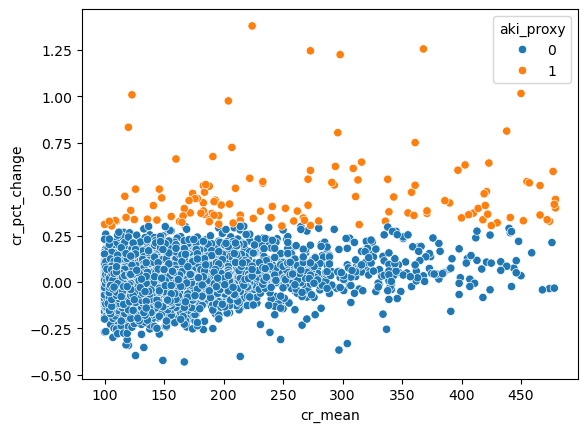

In [36]:
sns.scatterplot(data=drophighoutliers, x="cr_mean", y="cr_pct_change", hue="aki_proxy")

In [37]:
#drop the non-binary version of the outcome so the model doesn't cheat by using it :)
raw = raw.drop(columns=["cr_pct_change", "cr_vlast"]) 

# Train-Test-Validate Split

In [38]:
#split into x and y

xraw = raw.drop(columns=["aki_proxy"])
print(xraw.shape)

yraw = raw["aki_proxy"]
print(yraw.shape)
#print(yraw)
print(yraw.value_counts())

(8722, 55)
(8722,)
0    8586
1     136
Name: aki_proxy, dtype: int64


In [39]:
#NOTE: need to use the stratify option here given the huge imbalance

np.random.seed(0) #but note this isn't threadsafe

#split into train and remainder #############################################################################
x_train, x_test_temp, y_train, y_test_temp = train_test_split(
    xraw, yraw
    , train_size = 0.7, test_size = 0.3
    , random_state = 123 #seed
    #, shuffle = True
    , stratify=yraw #added for imbalance 
)

#note: unlike numpy random method, these are exactly at 70-30-30 split 
print(x_train.shape)
print(y_train.shape)
print(y_train.value_counts())

print(x_test_temp.shape)
print(y_test_temp.shape)


# Further split into test and validate ########################################################################
x_test, x_validate, y_test, y_validate = train_test_split(
    x_test_temp, y_test_temp
    , train_size = 0.5, test_size=0.5
    , random_state=123 #seed
    #, shuffle=True #shuffle before splitting
    , stratify=y_test_temp #added for imbalance 
)

print(x_test.shape)
print(y_test.shape)
print(y_test.value_counts())

print(x_validate.shape)
print(y_validate.shape)
print(y_validate.value_counts())


(6105, 55)
(6105,)
0    6010
1      95
Name: aki_proxy, dtype: int64
(2617, 55)
(2617,)
(1308, 55)
(1308,)
0    1288
1      20
Name: aki_proxy, dtype: int64
(1309, 55)
(1309,)
0    1288
1      21
Name: aki_proxy, dtype: int64


In [40]:
#export
raw.to_csv(r"C:\Users\evalb\Box\Courses\BMI5111_Capstone\Data\fororange_finalraw.csv", index=False)


# Various cleanup 

In [41]:
print(x_train.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6105 entries, 21078 to 26350
Data columns (total 55 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   latestage                                6105 non-null   float64
 1   minsbp                                   6054 non-null   float64
 2   mindbp                                   6054 non-null   float64
 3   maxsbp                                   6054 non-null   float64
 4   maxdbp                                   6054 non-null   float64
 5   no_of_visits                             6105 non-null   float64
 6   hba1c_mean                               4702 non-null   float64
 7   potassium_max                            4841 non-null   float64
 8   egfr_mean                                6100 non-null   float64
 9   cr_mean                                  6105 non-null   float64
 10  uacr_mean                                46

In [42]:
#print(raw.info(verbose=True))

#this no longer works b/c the dummies are all numeric now -- all float64 OR uint8  (dummies) 
#xtrain_cat_cols = x_train.select_dtypes("category").columns
#xtrain_obj_cols = x_train.select_dtypes("object").columns
#xtrain_num_cols = x_train.select_dtypes(exclude=["category","object"]).columns
xtrain_flag_cols =  x_train.select_dtypes(exclude=["float64"]).columns
xtrain_num_cols = x_train.select_dtypes(exclude=["uint8"]).columns 

print(xtrain_flag_cols)
print(xtrain_num_cols)

print(x_train.shape[1] == len(xtrain_flag_cols)+len(xtrain_num_cols))


Index(['dummy', 'gender_Male', 'ethnicity4_Indian', 'ethnicity4_Malay',
       'ethnicity4_Others', 'diabetes_Y', 'heart_dz_Y', 'stroke_Y', 'pvd_Y',
       'aki_ever_Y', 'raasi_Y', 'nsmra_Y', 'smra_Y', 'sglt2i_Y', 'metformin_Y',
       'statins_Y', 'esas_Y', 'raasi_percentmaxdose_vlast_50_99percent',
       'ip_count_ge5', 'calcium_levels_normal', 'phos_levels_normal',
       'age_ge75', 'sodium_missing', 'potassium_missing',
       'not_both_sglt2i_metformin', 'ge3_renalprot_drugs'],
      dtype='object')
Index(['latestage', 'minsbp', 'mindbp', 'maxsbp', 'maxdbp', 'no_of_visits',
       'hba1c_mean', 'potassium_max', 'egfr_mean', 'cr_mean', 'uacr_mean',
       'kfresea_5yrs', 'raasi_totaldosemg_v1', 'raasi_percentmaxdose_vlast',
       'raasi_percentdosechange', 'ip_days', 'egfr_pct_change_first_mean',
       'cr_pct_change_first_mean', 'dummy', 'has_visits_nuh', 'has_visits_ah',
       'has_visits_ntfgh', 'has_visits_bbk_ops', 'has_visits_bp_ops',
       'has_visits_cck_ops', 'has_vi

### Outliers

In [43]:
#Try clipping instead of dropping 
    #outliers: 2-3, so assuming the data is close enough to a normal distribution, 3 sd give us 99% of data, etc

#store the original version
x_train_withoutliers = x_train.copy(deep=True)

print(x_train.shape)

#loop through columns and remove outliers far from mean (3x standard deviation)
for c in xtrain_num_cols:
    
    #print(f"""now processing {c}""")
        
    upper = x_train[c].mean() + 3*x_train[c].std()
    lower = x_train[c].mean() - 3*x_train[c].std()  #may go negative
    
    #print(upper)
    #print(lower)

    #truncate: 
    x_train[c] = [lower if x < lower else upper if x > upper else x for x in x_train[c]]     

#confirm no rows dropped
print(x_train.shape)   


'''
#look at a few
print(x_train_withoutliers["latestage"].describe())
print(x_train["latestage"].describe())

print(x_train_withoutliers["raasi_percentdosechange"].describe())
print(x_train["raasi_percentdosechange"].describe())
'''


(6105, 55)
(6105, 55)


'\n#look at a few\nprint(x_train_withoutliers["latestage"].describe())\nprint(x_train["latestage"].describe())\n\nprint(x_train_withoutliers["raasi_percentdosechange"].describe())\nprint(x_train["raasi_percentdosechange"].describe())\n'

In [44]:
#x_train_withoutliers.to_csv(r"C:\Users\evalb\Box\Courses\BMI5111_Capstone\Data\fororange_prestandardize.csv", index=False)


### Standardize features

In [45]:
print(xtrain_num_cols)

Index(['latestage', 'minsbp', 'mindbp', 'maxsbp', 'maxdbp', 'no_of_visits',
       'hba1c_mean', 'potassium_max', 'egfr_mean', 'cr_mean', 'uacr_mean',
       'kfresea_5yrs', 'raasi_totaldosemg_v1', 'raasi_percentmaxdose_vlast',
       'raasi_percentdosechange', 'ip_days', 'egfr_pct_change_first_mean',
       'cr_pct_change_first_mean', 'dummy', 'has_visits_nuh', 'has_visits_ah',
       'has_visits_ntfgh', 'has_visits_bbk_ops', 'has_visits_bp_ops',
       'has_visits_cck_ops', 'has_visits_clem_ops', 'has_visits_jur_ops',
       'has_visits_pioneer_ops', 'has_visits_qt_ops', 'age_ge75_ipcount_ge5'],
      dtype='object')


In [ ]:
#store the original version
x_train_prenorm = x_train.copy(deep=True)

#need to store the values for normalizing the test and validation data 
xtrain_mean_list  = []
xtrain_std_list = []

for c in x_train.columns:
    
    if c in xtrain_num_cols:
        #print(c)
        mean = ''
        std = '' 
        
        mean = x_train[c].mean()
        std = x_train[c].std()
        xtrain_mean_list.append(mean)
        xtrain_std_list.append(std)
        #print(mean)
        #print(std) 
        
        #apply train mean/std to train data
        x_train[c] = [((x-mean)/std) for x in x_train[c]]
        
        #apply train mean/std to test data
        x_test[c] = [((x-mean)/std) for x in x_test[c]]
        
        #apply train mean/std to validation data
        x_validate[c] = [((x-mean)/std) for x in x_validate[c]]
        
        
    #else:
        #print(f"""skipped {c}""")
        

#good: can see mean right around 0 (very small off from 0), std at 1 (for train, others are more diff as expected) 
#print(x_train["ip_days"].describe())
print(x_train[xtrain_num_cols].describe()) 
#print(x_test[xtrain_num_cols].describe()) 
#print(x_validate[xtrain_num_cols].describe()) 

#set up values in dataframe for use later
    #https://cmdlinetips.com/2018/01/how-to-create-pandas-dataframe-from-multiple-lists/

data_tuples = list(zip(xtrain_num_cols,xtrain_mean_list,xtrain_std_list))
train_mean_std = pd.DataFrame(data_tuples, columns = ['variable', 'mean_train', 'std_train'])
#print(train_mean_std.head(100))


### Address missing values

In [48]:
#not too many! 
print(x_train.info(verbose=True, show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6105 entries, 21078 to 26350
Data columns (total 55 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   latestage                                6105 non-null   float64
 1   minsbp                                   6054 non-null   float64
 2   mindbp                                   6054 non-null   float64
 3   maxsbp                                   6054 non-null   float64
 4   maxdbp                                   6054 non-null   float64
 5   no_of_visits                             6105 non-null   float64
 6   hba1c_mean                               4702 non-null   float64
 7   potassium_max                            4841 non-null   float64
 8   egfr_mean                                6100 non-null   float64
 9   cr_mean                                  6105 non-null   float64
 10  uacr_mean                                46

In [49]:
#populate with mean 
    #https://scikit-learn.org/stable/modules/impute.html
    #https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py
    #https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer.set_output

#store the original version
x_train_preimpute = x_train.copy(deep=True)

In [50]:
#since they're normalized already, could just set missing to 0 and it would BE mean imputation
#but use the fitter for practice :) 

print(x_train.shape)
print(x_train.columns)

#numeric - mean imputation #######################################################################################
#use set_output to return a pandas df instead of a np array 
imp = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False). set_output(transform="pandas")

x_train_num = x_train[xtrain_num_cols]
#print(x_train_num.columns)

imp.fit(x_train_num)

SimpleImputer()

x_train_num = imp.transform(x_train_num)

#print(x_train_num.describe())

#apply train mean's to test and validate
x_test_num = imp.transform(x_test[xtrain_num_cols])
x_validate_num = imp.transform(x_validate[xtrain_num_cols])


#non-numeric - most frequent imputation ############################################################################
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent', copy=False). set_output(transform="pandas")

x_train_nonnum = x_train[xtrain_flag_cols]
#print(x_train_nonnum.columns)

imp2.fit(x_train_nonnum)

SimpleImputer()

x_train_nonnum = imp2.transform(x_train_nonnum)

#print(x_train_nonnum.describe())

#apply train most freq to test and validate
x_test_nonnum = imp2.transform(x_test[xtrain_flag_cols])
x_validate_nonnum = imp2.transform(x_validate[xtrain_flag_cols])

#recombine #######################################################################################################
x_train = pd.concat([x_train_num,x_train_nonnum],axis=1)
print(x_train.shape)
#print(x_train.info(verbose=True, show_counts=True))

x_test = pd.concat([x_test_num,x_test_nonnum],axis=1)
print(x_test.shape)

x_validate = pd.concat([x_validate_num,x_validate_nonnum],axis=1)
print(x_validate.shape)

(6105, 55)
Index(['latestage', 'minsbp', 'mindbp', 'maxsbp', 'maxdbp', 'no_of_visits',
       'hba1c_mean', 'potassium_max', 'egfr_mean', 'cr_mean', 'uacr_mean',
       'kfresea_5yrs', 'raasi_totaldosemg_v1', 'raasi_percentmaxdose_vlast',
       'raasi_percentdosechange', 'ip_days', 'egfr_pct_change_first_mean',
       'cr_pct_change_first_mean', 'dummy', 'has_visits_nuh', 'has_visits_ah',
       'has_visits_ntfgh', 'has_visits_bbk_ops', 'has_visits_bp_ops',
       'has_visits_cck_ops', 'has_visits_clem_ops', 'has_visits_jur_ops',
       'has_visits_pioneer_ops', 'has_visits_qt_ops', 'gender_Male',
       'ethnicity4_Indian', 'ethnicity4_Malay', 'ethnicity4_Others',
       'diabetes_Y', 'heart_dz_Y', 'stroke_Y', 'pvd_Y', 'aki_ever_Y',
       'raasi_Y', 'nsmra_Y', 'smra_Y', 'sglt2i_Y', 'metformin_Y', 'statins_Y',
       'esas_Y', 'raasi_percentmaxdose_vlast_50_99percent', 'ip_count_ge5',
       'calcium_levels_normal', 'phos_levels_normal', 'age_ge75',
       'sodium_missing', 'potassiu

# Check for Multicollinearity Among Features

In [51]:
#adding constant per author's flag
    #https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
    #https://github.com/statsmodels/statsmodels/issues/2376
    
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    
    return vifs

vif_scores_w_constant = variance_inflation_factors(x_train).to_frame()

In [52]:
#ISLP textbook: As a rule of thumb, a VIF value that exceeds 5 or 10 indicates a problematic amount of collinearity.
print(vif_scores_w_constant[vif_scores_w_constant["VIF"] > 5].sort_values("VIF", ascending=False))

#remaining over 5 (but under 10): 
    #not_both_sglt2i_metformin, ge3_renalprot_drugs, cr_mean, egfr_mean

#decision: keep for now 

                                  VIF
const                      239.394752
not_both_sglt2i_metformin    9.069590
ge3_renalprot_drugs          9.047236
egfr_mean                    8.812704
cr_mean                      8.789871


# SMOTE

In [53]:

    
x_train_presmote = x_train.copy(deep=True)
y_train_presmote = y_train.copy(deep=True)

print("pre-smote:")
print(x_train.shape)
print(y_train.shape)
print(y_train.value_counts())

#rs for resampled:
    #https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
x_train, y_train = SMOTE(sampling_strategy='minority', random_state=123).fit_resample(x_train, y_train)

print("post-smote:")
print(x_train.shape)
print(y_train.shape)
print(y_train.value_counts())

pre-smote:
(6105, 54)
(6105,)
0    6010
1      95
Name: aki_proxy, dtype: int64
post-smote:
(12020, 54)
(12020,)
0    6010
1    6010
Name: aki_proxy, dtype: int64


# Compute class and sample weights 

In [54]:
#class weights
fs_class_weight_dict = {0:0.45, 1:0.55}

print(fs_class_weight_dict)

{0: 0.45, 1: 0.55}


In [55]:
#sample_weights 
#https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html
fs_calced_sample_weights = compute_sample_weight(class_weight=fs_class_weight_dict, y=y_test)

fs_calced_sample_weights_train = compute_sample_weight(class_weight=fs_class_weight_dict, y=y_train)

# Feature selection

In [56]:
#The model must include features for the drug classes individually [confirmed 2/2]

fs_Cs = [0.001, 0.01, 0.05, 0.1, 0.2 , 0.3] #, 0.4, 0.5] #, 0.6, 0.7, 0.8, 0.9, 1.0]

In [57]:
#reorder columns in test data to match column order in training data
'''
train_col_order = x_train.columns

don't currently need
x_test = x_test[train_col_order]
print(x_test.columns)
'''

"\ntrain_col_order = x_train.columns\n\ndon't currently need\nx_test = x_test[train_col_order]\nprint(x_test.columns)\n"

highest-performing value for C: [0.3]
0.9497289305076392
0.33452593917710194
0.29310344827586204
number of features GE 0.01: 45
sodium_missing                            -2.025476
cr_pct_change_first_mean                   1.730249
ethnicity4_Indian                         -1.399402
gender_Male                               -1.378374
statins_Y                                 -1.080268
ge3_renalprot_drugs                       -0.994595
cr_mean                                    0.839170
ip_count_ge5                              -0.818978
smra_Y                                     0.793646
phos_levels_normal                        -0.743319
maxsbp                                     0.676822
no_of_visits                               0.613827
calcium_levels_normal                      0.578281
esas_Y                                    -0.547882
has_visits_jur_ops                         0.459588
potassium_missing                          0.450244
aki_ever_Y                              

<Axes: >

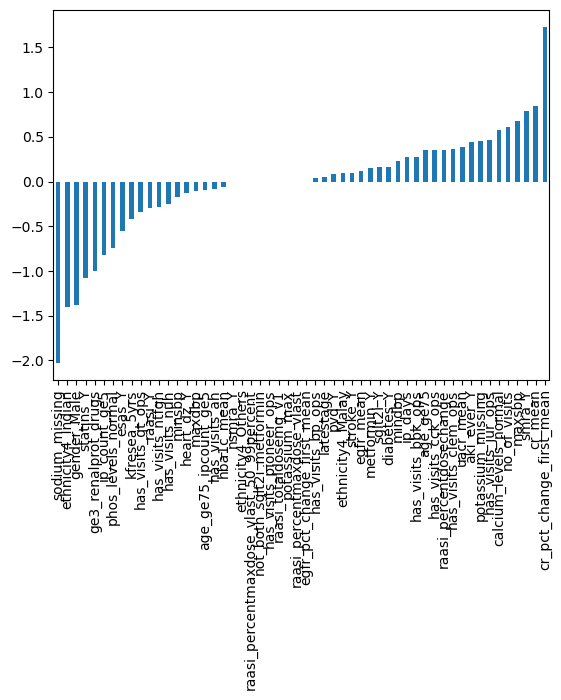

In [58]:
#Logistic Reg w/ L1 Regularization (also functions as feature selection)

fs_model_lr_l1 = LogisticRegressionCV(
    penalty='l1',
    solver='liblinear',  #if I'm using L1, looks like I can only pick liblinear and saga. sklearn recommends liblinear for small datasets
    Cs=fs_Cs, #will try all of these and use the cv to pick the best one
    fit_intercept=True,
    cv=5,
    n_jobs = -1,
    tol = 0.001,
    scoring="f1",
    class_weight = fs_class_weight_dict
    ).fit(x_train, y_train)

#smote means training is balanced, but test and eval won't be 
fs_train_score_lr_l1 = fs_model_lr_l1.score(x_train,y_train)
fs_test_score_lr_l1 = fs_model_lr_l1.score(x_test,y_test,sample_weight=fs_calced_sample_weights) #added the sample weights here
fs_model_lr_l1_y_pred = fs_model_lr_l1.predict(x_test) #for f1:


print(f"""highest-performing value for C: {fs_model_lr_l1.C_}""")
print(fs_train_score_lr_l1) 
print(fs_test_score_lr_l1) 
print(f1_score(y_test, fs_model_lr_l1_y_pred))

print(f"""number of features GE 0.01: {(abs(fs_model_lr_l1.coef_) >=0.01).sum()}""")

print(pd.Series(fs_model_lr_l1.coef_[0], x_train.columns).sort_values(key=abs, ascending = False).head(50))

pd.Series(fs_model_lr_l1.coef_[0], x_train.columns).sort_values(ascending = True).plot(kind = "bar")


highest-performing value for C: [0.3]
0.9497041420118344
0.3318544809228038
0.2905982905982906
number of features GE 0.01: 51
sodium_missing                            -1.881221
cr_pct_change_first_mean                   1.736810
gender_Male                               -1.426659
ethnicity4_Indian                         -1.191200
ge3_renalprot_drugs                       -1.115521
statins_Y                                 -1.105515
calcium_levels_normal                      0.981918
cr_mean                                    0.974053
phos_levels_normal                        -0.895792
smra_Y                                     0.859930
ip_count_ge5                              -0.808543
maxsbp                                     0.721693
no_of_visits                               0.643353
esas_Y                                    -0.635720
aki_ever_Y                                 0.613135
has_visits_jur_ops                         0.505867
age_ge75                                  

<Axes: >

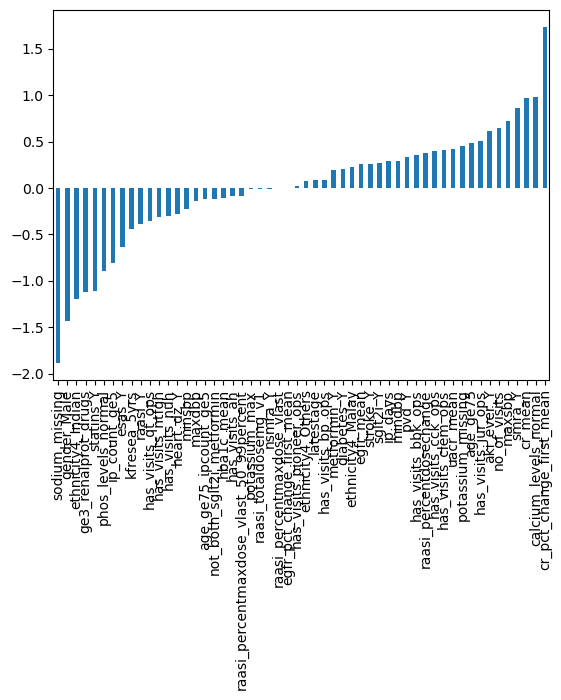

In [59]:
#Logistic Reg w/ L2 Regularization (will make coeff small but not all the way to 0)

fs_model_lr_l2 = LogisticRegressionCV(
    penalty='l2',
    solver='liblinear',  #if I'm using L2, looks like I have more options
    Cs=fs_Cs, #will try all of these and use the cv to pick the best one 
    fit_intercept=True,
    cv=5,
    n_jobs = -1,
    tol = 0.001,
    scoring="f1",
    class_weight = fs_class_weight_dict
    ).fit(x_train, y_train)

#smote means training is balanced, but test and eval won't be 
fs_train_score_lr_l2 = fs_model_lr_l2.score(x_train,y_train)
fs_test_score_lr_l2 = fs_model_lr_l2.score(x_test,y_test,sample_weight=fs_calced_sample_weights) #added the sample weights here)
fs_model_lr_l2_y_pred = fs_model_lr_l2.predict(x_test)


print(f"""highest-performing value for C: {fs_model_lr_l2.C_}""")
print(fs_train_score_lr_l2)
print(fs_test_score_lr_l2)
print(f1_score(y_test, fs_model_lr_l2_y_pred))


print(f"""number of features GE 0.01: {(abs(fs_model_lr_l2.coef_) >=0.01).sum()}""")

print(pd.Series(fs_model_lr_l2.coef_[0], x_train.columns).sort_values(key=abs, ascending = False).head(50))

pd.Series(fs_model_lr_l2.coef_[0], x_train.columns).sort_values(ascending = True).plot(kind = "bar")


In [60]:
#Recursive (type of backwards selection)
    #could fiddle with C
    #taking longer
    #NOTE: doesn't have class weights
   
'''
fs_RFECV = RFECV(
    estimator= LogisticRegression(penalty='l1', solver='liblinear', C=0.05, fit_intercept=True), #SVC(kernel="linear")
    step=1, #just remove 1 feature each time, no need for more than that 
    cv=3, #cross validation. default is 5 with stratifiedkfold. Set to 3 b/c my computer is struggling to run :( 
    n_jobs = -1,
    scoring = "f1",

    )

fs_RFECV  = selector.fit(x_train, y_train)

#still accuracy 
print(fs_RFECV .get_feature_names_out())
print(fs_RFECV .score(x_train, y_train))  
print(fs_RFECV .score(x_test, y_test)) #doesn't allow weights - could try to add them in the estimator above?

#print(fs_RFECV .score(x_test, y_test, f1_score))  

fs_RFECV_y_pred  =  fs_RFECV .predict(x_test)
print(f1_score(y_test, fs_RFECV_y_pred))
print(f1_score(y_test, fs_RFECV_y_pred, average=None))
'''

'\nfs_RFECV = RFECV(\n    estimator= LogisticRegression(penalty=\'l1\', solver=\'liblinear\', C=0.05, fit_intercept=True), #SVC(kernel="linear")\n    step=1, #just remove 1 feature each time, no need for more than that \n    cv=3, #cross validation. default is 5 with stratifiedkfold. Set to 3 b/c my computer is struggling to run :( \n    n_jobs = -1,\n    scoring = "f1",\n\n    )\n\nfs_RFECV  = selector.fit(x_train, y_train)\n\n#still accuracy \nprint(fs_RFECV .get_feature_names_out())\nprint(fs_RFECV .score(x_train, y_train))  \nprint(fs_RFECV .score(x_test, y_test)) #doesn\'t allow weights - could try to add them in the estimator above?\n\n#print(fs_RFECV .score(x_test, y_test, f1_score))  \n\nfs_RFECV_y_pred  =  fs_RFECV .predict(x_test)\nprint(f1_score(y_test, fs_RFECV_y_pred))\nprint(f1_score(y_test, fs_RFECV_y_pred, average=None))\n'

0.9448419301164726
0.9170335252285812
0.2285714285714286
                                    feature  importance
17                 cr_pct_change_first_mean    0.289176
16               egfr_pct_change_first_mean    0.107851
9                                   cr_mean    0.101605
8                                 egfr_mean    0.096655
3                                    maxsbp    0.075414
15                                  ip_days    0.061669
44                                   esas_Y    0.057523
18                           has_visits_nuh    0.041077
11                             kfresea_5yrs    0.021042
48                       phos_levels_normal    0.018904
10                                uacr_mean    0.018306
29                              gender_Male    0.015218
46                             ip_count_ge5    0.013845
4                                    maxdbp    0.012914
5                              no_of_visits    0.012855
34                               heart_dz_Y    

<Axes: xlabel='importance', ylabel='feature'>

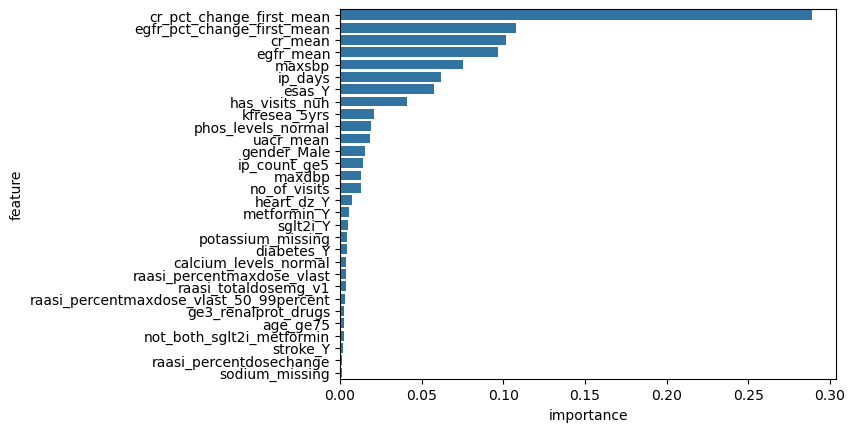

In [61]:
#Random Forest (in case data is better fit by splitting than linear boundary) 

#try max depth of 3 
fs_rfc = RFC(
    max_depth=3, 
    random_state=0, 
    criterion="entropy",
    n_jobs=-1,
    #addl efforts to avoid overfitting:
    bootstrap=True, #build trees on bootstrap samples instead of whole dataset
    oob_score = True,
    class_weight = fs_class_weight_dict
    )

fs_rfc.fit(x_train, y_train)

#also returns mean accuracy; not great to use here 
fs_rfc_train_score = fs_rfc.score(x_train,y_train)
fs_rfc_ttest_score = fs_rfc.score(x_test,y_test,sample_weight=fs_calced_sample_weights) #added the sample weights here))
print(fs_rfc_train_score)
print(fs_rfc_ttest_score)

#show F1:
fs_rfc_y_pred =  fs_rfc.predict(x_test)
#print(clf_y_pred)
#see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
print(f1_score(y_test, fs_rfc_y_pred)) #default is binary: Only report results for the class specified by pos_label (deafult is 1) 


#create df of the feature importances 
data_tuples = list(zip(fs_rfc.feature_names_in_,fs_rfc.feature_importances_))
fs_rfc_varimport = pd.DataFrame(data_tuples, columns = ['feature', 'importance'])

#visualize
print(fs_rfc_varimport.sort_values("importance", ascending=False).head(50))
sns.barplot(data=fs_rfc_varimport.sort_values("importance", ascending=False).head(30), x="importance", y="feature")



In [62]:
#try permutation importance instead
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

from sklearn.inspection import permutation_importance


result = permutation_importance(
    fs_rfc, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

#conver to pandas 
forest_importances = pd.Series(result.importances_mean, index=fs_rfc.feature_names_in_)


In [63]:
print(type(forest_importances))

print(forest_importances.sort_values(ascending=False, key=abs).head(55))


<class 'pandas.core.series.Series'>
cr_pct_change_first_mean                  -0.036468
egfr_pct_change_first_mean                -0.025994
maxsbp                                    -0.010398
egfr_mean                                 -0.009021
cr_mean                                   -0.006575
ip_days                                   -0.006422
kfresea_5yrs                              -0.004740
gender_Male                               -0.002676
has_visits_nuh                            -0.002446
no_of_visits                              -0.002370
raasi_percentmaxdose_vlast_50_99percent    0.001911
uacr_mean                                 -0.001758
heart_dz_Y                                 0.001682
stroke_Y                                  -0.001606
metformin_Y                               -0.001070
esas_Y                                    -0.001070
ip_count_ge5                              -0.000994
diabetes_Y                                -0.000765
hba1c_mean                  

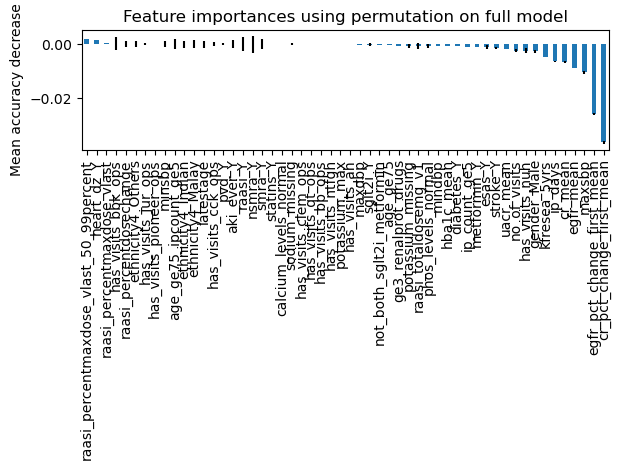

In [64]:

fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Model Training

In [67]:
#Prep SHAP for below
    #there seems to be some issue where SHAP is expecting a different format (one that has changed over time, hence tutorials are out of date?)
    #write my own reformatting function:

def prep_for_shap(df):
    test_list = [] 

    for r in range(0,shap_values.shape[0]):
        datapoint_level = []

        for x in range(0,shap_values.shape[1]):
            datapoint_level.append(shap_values[r][x][1]) #1 is fixed b/c it's the second value in the list of 2, aka outcome class value

        test_list.append(datapoint_level)
        
    #convert to array as required by SHAP
    test_arr = np.array(test_list)
        
    return test_arr


def prep_for_shap_0(df):
    test_list_0 = []

    for r in range(0,shap_values.shape[0]):
        datapoint_level_0 = []

        for x in range(0,shap_values.shape[1]):
            datapoint_level_0.append(shap_values[r][x][0]) #1 is fixed b/c it's the second value in the list of 2, aka outcome class value

        test_list_0.append(datapoint_level_0)
        
    #convert to array as required by SHAP
    test_arr_0 = np.array(test_list_0)
        
    return test_arr_0 


In [68]:
#test two different lists to see how they perform
#note: MUST remember to include the drug features regardless of what the algo puts out b/c I need them for my goal 

drug_flag_cols2 = ["raasi_Y", "nsmra_Y", "smra_Y", "sglt2i_Y", "metformin_Y"]  

#now this is rf plus whole categorical list where required 
feat_less = ["cr_pct_change_first_mean", "egfr_pct_change_first_mean", "cr_mean", "egfr_mean", "maxsbp", "ip_days", "esas_Y", 
             "has_visits_nuh", "kfresea_5yrs", "phos_levels_normal", "uacr_mean", "gender_Male", "ip_count_ge5", "maxdbp", 
             "no_of_visits", "heart_dz_Y", "metformin_Y", "sglt2i_Y", "potassium_missing", "diabetes_Y", "calcium_levels_normal",
             "raasi_percentmaxdose_vlast", "raasi_totaldosemg_v1", "raasi_percentmaxdose_vlast_50_99percent", "ge3_renalprot_drugs", 
             "age_ge75", "not_both_sglt2i_metformin", "stroke_Y", "raasi_percentdosechange"
            ]

#l2 log plus whole categorical list where required 
feat_more = ["sodium_missing", "cr_pct_change_first_mean", "ethnicity4_Indian", "gender_Male", "statins_Y", "ge3_renalprot_drugs", 
             "cr_mean", "ip_count_ge5", "smra_Y", "phos_levels_normal", "maxsbp", "no_of_visits", "calcium_levels_normal", "esas_Y",
             "has_visits_jur_ops", "potassium_missing", "aki_ever_Y", "kfresea_5yrs", "uacr_mean", "has_visits_clem_ops", "raasi_percentdosechange",
             "age_ge75", "has_visits_cck_ops", "has_visits_qt_ops", "raasi_Y", "has_visits_ntfgh", "ip_days", "has_visits_bbk_ops", "has_visits_nuh",
             "mindbp",             
             #not selected but part of the original categorical var:
            'ethnicity4_Malay', 'ethnicity4_Others'            
            ]


#add in drug flag cols if not already in there: 
for c in drug_flag_cols2:
    print(c)
    if c not in feat_more:
        print('appending')
        feat_more.append(c)
        
    if c not in feat_less:
        feat_less.append(c)

print(len(feat_more), feat_more)
print(len(feat_less), feat_less)


#create dfs for each subset of features 
x_train_more = x_train[feat_more]
print(x_train_more.shape)

x_train_less = x_train[feat_less]
print(x_train_less.shape)

x_test_more = x_test[feat_more]
print(x_test_more.shape)

x_test_less = x_test[feat_less]
print(x_test_less.shape)

raasi_Y
nsmra_Y
appending
smra_Y
sglt2i_Y
appending
metformin_Y
appending
35 ['sodium_missing', 'cr_pct_change_first_mean', 'ethnicity4_Indian', 'gender_Male', 'statins_Y', 'ge3_renalprot_drugs', 'cr_mean', 'ip_count_ge5', 'smra_Y', 'phos_levels_normal', 'maxsbp', 'no_of_visits', 'calcium_levels_normal', 'esas_Y', 'has_visits_jur_ops', 'potassium_missing', 'aki_ever_Y', 'kfresea_5yrs', 'uacr_mean', 'has_visits_clem_ops', 'raasi_percentdosechange', 'age_ge75', 'has_visits_cck_ops', 'has_visits_qt_ops', 'raasi_Y', 'has_visits_ntfgh', 'ip_days', 'has_visits_bbk_ops', 'has_visits_nuh', 'mindbp', 'ethnicity4_Malay', 'ethnicity4_Others', 'nsmra_Y', 'sglt2i_Y', 'metformin_Y']
32 ['cr_pct_change_first_mean', 'egfr_pct_change_first_mean', 'cr_mean', 'egfr_mean', 'maxsbp', 'ip_days', 'esas_Y', 'has_visits_nuh', 'kfresea_5yrs', 'phos_levels_normal', 'uacr_mean', 'gender_Male', 'ip_count_ge5', 'maxdbp', 'no_of_visits', 'heart_dz_Y', 'metformin_Y', 'sglt2i_Y', 'potassium_missing', 'diabetes_Y', 'ca

## Set models and parameters for grid search

In [69]:
#parameters that are the same across all iterations of grid search:

#cross validation on training data 
stratifiedCV = StratifiedKFold(n_splits=8)

#new: grid search the class weights
    #for now just copy and paste into all below
#grid_values = {'class_weight':['balanced', {1:2},{1:3},{1:4},{1:5},{1:10},{1:20},{1:50}]}

class_weight_dict = [{0:0.25, 1:0.75}, {0:0.45, 1:0.55}, {0:0.5, 1:0.5}] #still include equal as a baseline or in case that is best
    #do not include:  {0:0.55, 1:0.45}, {0:0.75, 1:0.25}

scale_pos_weight_list = [1.0, 1.2, 1.5, 2.0, 3.0] #this is a bit diff per https://xgboost.readthedocs.io/en/latest/parameter.html 


In [70]:
#prep gridsearch
    #set up GS parameters per model 
    #use with Halving to save time
    #turn off class weights in the model itself if I'm putting them in here 

model_lr_l1 = LogisticRegression(
    penalty='l1',
    solver='liblinear',  #if I'm using L1, looks like I can only pick liblinear and saga. sklearn recommends liblinear for small datasets
    fit_intercept=True,
    #tol = 0.001,
    #class_weight = fs_class_weight_dict
    random_state=0
    )

model_lr_l2 = LogisticRegression(
    penalty='l2',
    solver='liblinear',  #if I'm using L2, looks like I have more options
    fit_intercept=True,
    #tol = 0.001,
    #class_weight = fs_class_weight_dict
    random_state=0
    )

model_rfc = RFC(
    #addl efforts to avoid overfitting:
    bootstrap=True, #build trees on bootstrap samples instead of whole dataset
    oob_score = True,
    #class_weight = fs_class_weight_dict
    random_state=123
    )

model_xgb = XGBC(random_state=0, seed=123 ) #added 1/4/24

model_svm_rbf = SVC(kernel='rbf', probability=True, random_state=0)

model_svm_linear = SVC(kernel='linear', probability=True, random_state=0)


#gsp is grid search params 
    #try more parameters for xgb
        #https://medium.com/@rithpansanga/the-main-parameters-in-xgboost-and-their-effects-on-model-performance-4f9833cac7c
params = {
    'gsp_lr_l1':{
        'C':np.arange(start=0.001, stop=0.25, step=0.05), #20 values to test
        'class_weight':class_weight_dict
    },
    'gsp_lr_l2':{
        'C':np.arange(start=0.001, stop=0.25, step=0.05), #20 values to test
        'class_weight':class_weight_dict
    },
    'gsp_rfc':{
        'max_depth':np.arange(start=1,stop=10), #expanded to 12; brought back down 
        'class_weight':class_weight_dict
    },
    'gsp_xgb':{
        'n_estimators': [18, 40, 48, 50], #[50, 52, 75, 100], #[38, 42, 48], #[20, 30, 40],
        'max_depth':np.arange(start=2,stop=5),  #max depth of a tree; expanded after initial run; shrunk again
        'learning_rate':np.arange(start=0.01,stop=0.4,step=0.05), #step size shrinkage; try starting at 0.01 instead of 0.05
        'subsample':[0.5, 0.6, 0.7, 0.8, 0.9], #randomly sample this % of data one for each boosting operation (prevents overfitting); added
        'colsample_bytree': [0.5, 0.75, 1], #subsample radio of the columns for constructing each tree (prevents overfitting); added
        'lambda': [1,2,3], #L2 regularization  on the weights; added default is 1
        'scale_pos_weight':scale_pos_weight_list
    },
    'gsp_svm':{
        'C':np.arange(0.5,5.5,step=1), #if I use and can run, try more 
        'class_weight':class_weight_dict
    }
    }


#### Logistic w/ L1 Reg more vs less features

In [71]:
best_lr_l1_more = HalvingGridSearchCV(
        model_lr_l1,
        param_grid = params['gsp_lr_l1'],
        scoring='f1', #important to use f1 instead of default of accuracy given my imbalance
        cv=stratifiedCV,
        n_jobs=-1
        ).fit(x_train_more, y_train) #I already have class weights, so I think I don't want these in here b/c it will multiple them together per documentation

best_lr_l1_more_y_pred_train = best_lr_l1_more.predict(x_train_more)
print('Training f1: ',f1_score(y_train, best_lr_l1_more_y_pred_train, average=None)) #print both

best_lr_l1_more_y_pred = best_lr_l1_more.predict(x_test_more)
print('Testing f1: ',f1_score(y_test, best_lr_l1_more_y_pred, average=None))

#show which set of parameters were best in grid search: 
print(pd.DataFrame([best_lr_l1_more.best_params_]))


Training f1:  [0.94033853 0.94118619]
Testing f1:  [0.96305221 0.26984127]
       C        class_weight
0  0.151  {0: 0.45, 1: 0.55}


In [130]:
#predict proba here 
best_lr_l1_more_y_prob = pd.DataFrame(best_lr_l1_more.predict_proba(x_test_more))

print('AUC: ',roc_auc_score(y_test, best_lr_l1_more_y_pred))

AUC:  0.8904503105590063


In [72]:
best_lr_l1_less = HalvingGridSearchCV(
        model_lr_l1,
        param_grid = params['gsp_lr_l1'],
        scoring='f1', #important to use f1 instead of default of accuracy given my imbalance
        cv=stratifiedCV,
        n_jobs=-1
        ).fit(x_train_less, y_train) #I already have class weights, so I think I don't want these in here b/c it will multiple them together per documentation

best_lr_l1_less_y_pred_train = best_lr_l1_less.predict(x_train_less)
print('Training f1: ',f1_score(y_train, best_lr_l1_less_y_pred_train, average=None)) #print both

best_lr_l1_less_y_pred = best_lr_l1_less.predict(x_test_less)
print('Testing f1: ',f1_score(y_test, best_lr_l1_less_y_pred, average=None))

#show which set of parameters were best in grid search: 
print(pd.DataFrame([best_lr_l1_less.best_params_]))

Training f1:  [0.932938   0.93883719]
Testing f1:  [0.94175554 0.20224719]
       C        class_weight
0  0.201  {0: 0.25, 1: 0.75}


In [73]:
#predict proba here 
best_lr_l1_less_y_prob = pd.DataFrame(best_lr_l1_less.predict_proba(x_test_less))

print('AUC: ',roc_auc_score(y_test, best_lr_l1_less_y_pred))

AUC:  0.8956521739130434


#### Logistic w/ L2 Reg more vs less features

In [74]:
best_lr_l2_more = HalvingGridSearchCV(
        model_lr_l2,
        param_grid = params['gsp_lr_l2'],
        scoring='f1', #important to use f1 instead of default of accuracy given my imbalance
        cv=stratifiedCV,
        n_jobs=-1
        ).fit(x_train_more, y_train) #I already have class weights, so I think I don't want these in here b/c it will multiple them together per documentation

best_lr_l2_more_y_pred_train = best_lr_l2_more.predict(x_train_more)
print('Training f1: ',f1_score(y_train, best_lr_l2_more_y_pred_train, average=None)) #print both

best_lr_l2_more_y_pred = best_lr_l2_more.predict(x_test_more)
print('Testing f1: ',f1_score(y_test, best_lr_l2_more_y_pred, average=None))

#show which set of parameters were best in grid search: 
print(pd.DataFrame([best_lr_l2_more.best_params_]))


Training f1:  [0.94394487 0.94506219]
Testing f1:  [0.96554487 0.28333333]
       C        class_weight
0  0.201  {0: 0.45, 1: 0.55}


In [131]:
#predict proba here 
best_lr_l2_more_y_prob = pd.DataFrame(best_lr_l2_more.predict_proba(x_test_more))

print('AUC: ',roc_auc_score(y_test, best_lr_l2_more_y_pred))

AUC:  0.8927795031055902


In [75]:
best_lr_l2_less = HalvingGridSearchCV(
        model_lr_l2,
        param_grid = params['gsp_lr_l2'],
        scoring='f1', #important to use f1 instead of default of accuracy given my imbalance
        cv=stratifiedCV,
        n_jobs=-1
        ).fit(x_train_less, y_train) #I already have class weights, so I think I don't want these in here b/c it will multiple them together per documentation

best_lr_l2_less_y_pred_train = best_lr_l2_less.predict(x_train_less)
print('Training f1: ',f1_score(y_train, best_lr_l2_less_y_pred_train, average=None)) #print both

best_lr_l2_less_y_pred = best_lr_l2_less.predict(x_test_less)
print('Testing f1: ',f1_score(y_test, best_lr_l2_less_y_pred, average=None))

#show which set of parameters were best in grid search: 
print(pd.DataFrame([best_lr_l2_less.best_params_]))


Training f1:  [0.93445912 0.93508859]
Testing f1:  [0.96096579 0.25954198]
       C        class_weight
0  0.201  {0: 0.45, 1: 0.55}


In [76]:
#predict proba here 
best_lr_l2_less_y_prob = pd.DataFrame(best_lr_l2_less.predict_proba(x_test_less))

print('AUC: ',roc_auc_score(y_test, best_lr_l2_less_y_pred))

AUC:  0.8885093167701864


#### Random Forest w/ more vs less features

Training f1:  [0.9949018  0.99494824]
Testing f1:  [0.98909657 0.41666667]
       class_weight  max_depth
0  {0: 0.5, 1: 0.5}          9
                     feature  importance
1   cr_pct_change_first_mean    0.316759
6                    cr_mean    0.100345
26                   ip_days    0.095733
10                    maxsbp    0.049674
28            has_visits_nuh    0.044135
3                gender_Male    0.044020
18                 uacr_mean    0.036635
13                    esas_Y    0.035469
9         phos_levels_normal    0.034200
7               ip_count_ge5    0.033743


<Axes: xlabel='importance', ylabel='feature'>

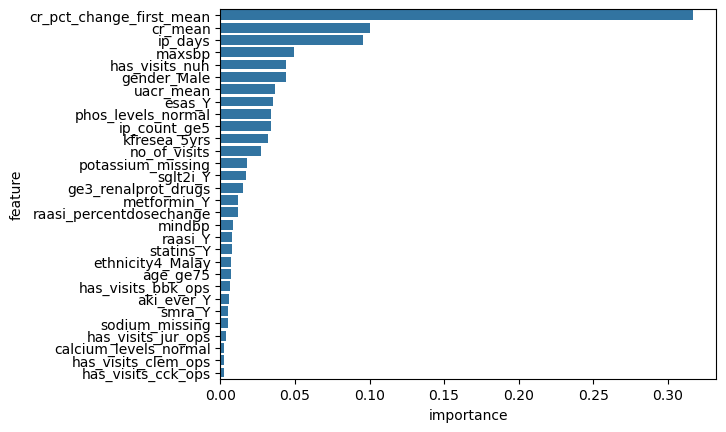

In [77]:
best_rfc_more = HalvingGridSearchCV(
        model_rfc,
        param_grid = params['gsp_rfc'],
        scoring='f1', #important to use f1 instead of default of accuracy given my imbalance
        cv=stratifiedCV,
        n_jobs=-1
        ).fit(x_train_more, y_train) #I already have class weights, so I think I don't want these in here b/c it will multiple them together per documentation

best_rfc_more_y_pred_train = best_rfc_more.predict(x_train_more)
print('Training f1: ',f1_score(y_train, best_rfc_more_y_pred_train, average=None)) #print both

best_rfc_more_y_pred = best_rfc_more.predict(x_test_more)
print('Testing f1: ',f1_score(y_test, best_rfc_more_y_pred, average=None))

#show which set of parameters were best in grid search: 
print(pd.DataFrame([best_rfc_more.best_params_]))

#create df of the feature importances
data_tuples = []
data_tuples = list(zip(best_rfc_more.feature_names_in_,best_rfc_more.best_estimator_.feature_importances_))
best_rfc_more_varimport = pd.DataFrame(data_tuples, columns = ['feature', 'importance'])

#visualize
print(best_rfc_more_varimport.sort_values("importance", ascending=False).head(10))
sns.barplot(data=best_rfc_more_varimport.sort_values("importance", ascending=False).head(30), x="importance", y="feature")


In [132]:
#predict proba here 
best_rfc_more_y_prob = pd.DataFrame(best_rfc_more.predict_proba(x_test_more))

print('AUC: ',roc_auc_score(y_test, best_rfc_more_y_pred))

AUC:  0.7430124223602486


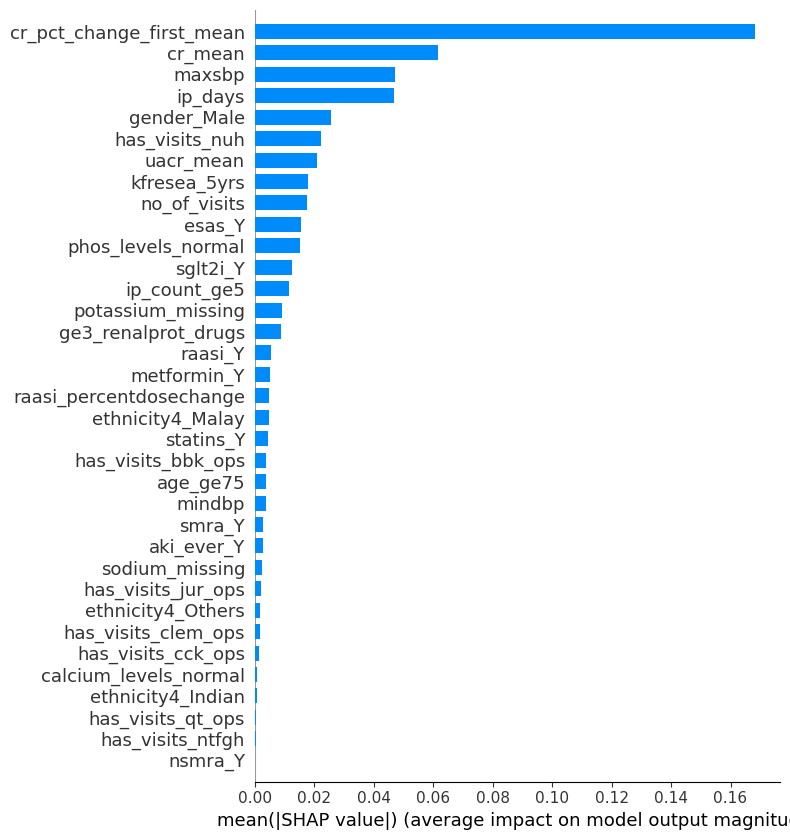

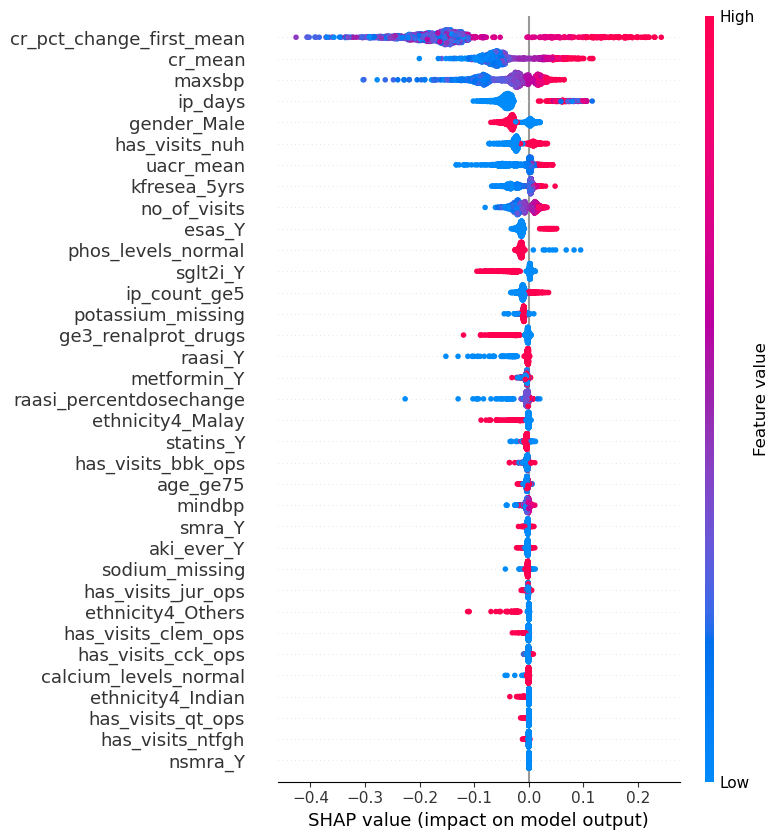

In [78]:
#SHAP for random forest more 
explainer = shap.TreeExplainer(best_rfc_more.best_estimator_) #have to use best estimator to grab the best model out of grid search
shap_values = explainer.shap_values(x_test_more) #use on test data 

test_arr = prep_for_shap(df=shap_values)
test_arr_0 = prep_for_shap_0(df=shap_values)

shap.summary_plot(test_arr, x_test_more, plot_size=0.2, plot_type='bar', max_display = 50)
shap.summary_plot(test_arr, x_test_more, plot_size=0.2, max_display = 50)

Training f1:  [0.9952369  0.99527872]
Testing f1:  [0.9898675 0.48     ]
       class_weight  max_depth
0  {0: 0.5, 1: 0.5}          9
                       feature  importance
0     cr_pct_change_first_mean    0.217275
2                      cr_mean    0.131305
3                    egfr_mean    0.125857
1   egfr_pct_change_first_mean    0.101114
5                      ip_days    0.069344
4                       maxsbp    0.051603
12                ip_count_ge5    0.028380
6                       esas_Y    0.027582
7               has_visits_nuh    0.027553
9           phos_levels_normal    0.024630


<Axes: xlabel='importance', ylabel='feature'>

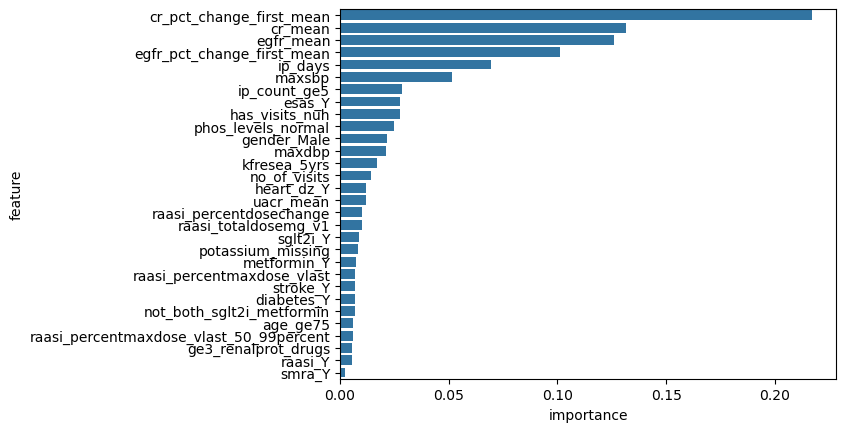

In [79]:
best_rfc_less = HalvingGridSearchCV(
        model_rfc,
        param_grid = params['gsp_rfc'],
        scoring='f1', #important to use f1 instead of default of accuracy given my imbalance
        cv=stratifiedCV,
        n_jobs=-1
        ).fit(x_train_less, y_train) #I already have class weights, so I think I don't want these in here b/c it will multiple them together per documentation

best_rfc_less_y_pred_train = best_rfc_less.predict(x_train_less)
print('Training f1: ',f1_score(y_train, best_rfc_less_y_pred_train, average=None)) #print both

best_rfc_less_y_pred = best_rfc_less.predict(x_test_less)
print('Testing f1: ',f1_score(y_test, best_rfc_less_y_pred, average=None))

#show which set of parameters were best in grid search: 
print(pd.DataFrame([best_rfc_less.best_params_]))

#create df of the feature importances 
data_tuples = []
data_tuples = list(zip(best_rfc_less.feature_names_in_,best_rfc_less.best_estimator_.feature_importances_))
best_rfc_less_varimport = pd.DataFrame(data_tuples, columns = ['feature', 'importance'])

#visualize
print(best_rfc_less_varimport.sort_values("importance", ascending=False).head(10))
sns.barplot(data=best_rfc_less_varimport.sort_values("importance", ascending=False).head(30), x="importance", y="feature")


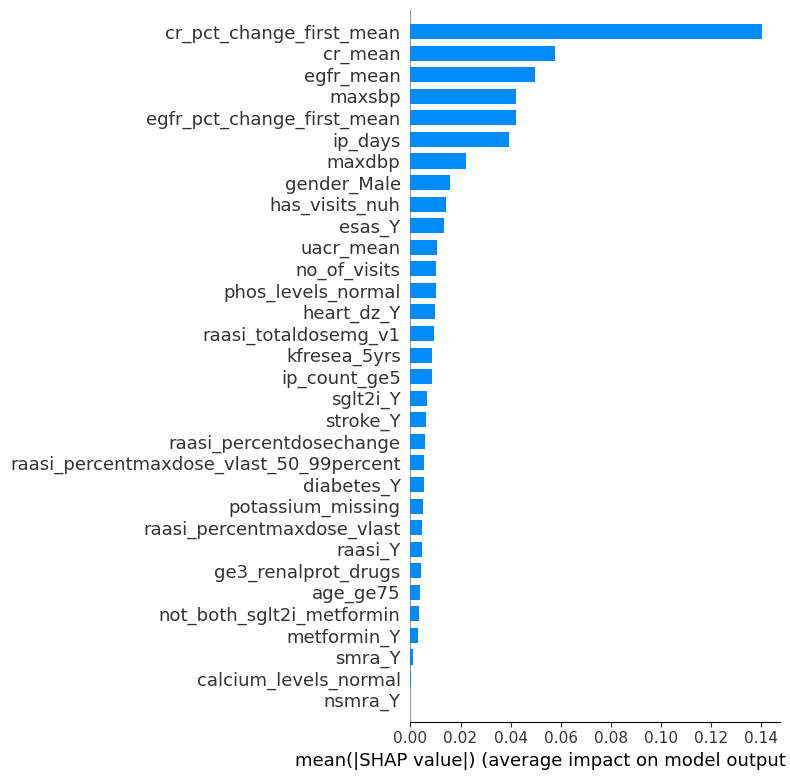

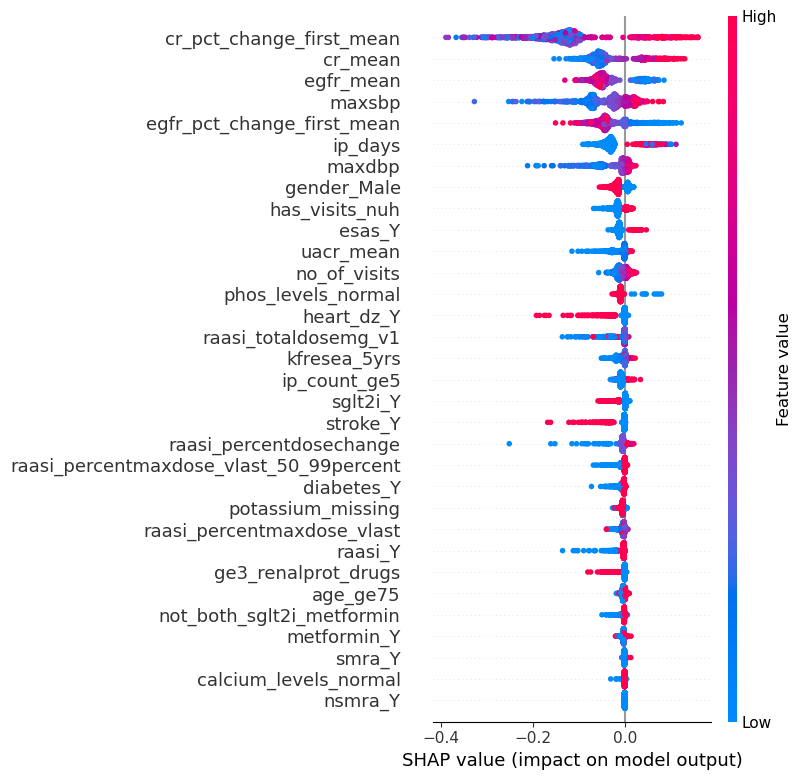

In [80]:
#SHAP for random forest less 
explainer = shap.TreeExplainer(best_rfc_less.best_estimator_) #have to use best estimator to grab the best model out of grid search
shap_values = explainer.shap_values(x_test_less) #use on test data 

test_arr = prep_for_shap(df=shap_values)
test_arr_0 = prep_for_shap_0(df=shap_values)

shap.summary_plot(test_arr, x_test_less, plot_size=0.2, plot_type='bar', max_display = 50)
shap.summary_plot(test_arr, x_test_less, plot_size=0.2, max_display = 50)

In [81]:
#predict proba here 
best_rfc_less_y_prob = pd.DataFrame(best_rfc_less.predict_proba(x_test_less))

print('AUC: ',roc_auc_score(y_test, best_rfc_less_y_pred))

AUC:  0.7930124223602485


#### XGBoost w/ more vs less features

##### XGBoost More

Training f1:  [0.99683755 0.99683965]
Testing f1:  [0.99378882 0.6       ]
   colsample_bytree  lambda  learning_rate  max_depth  n_estimators  \
0               0.5       1           0.21          4            50   

   scale_pos_weight  subsample  
0               1.2        0.8  
                     feature  importance
1   cr_pct_change_first_mean    0.243375
6                    cr_mean    0.147563
3                gender_Male    0.059553
26                   ip_days    0.054782
12     calcium_levels_normal    0.048057
10                    maxsbp    0.041152
7               ip_count_ge5    0.041136
13                    esas_Y    0.031060
9         phos_levels_normal    0.029725
19       has_visits_clem_ops    0.029608
27        has_visits_bbk_ops    0.022606
34               metformin_Y    0.022321
16                aki_ever_Y    0.017208
0             sodium_missing    0.016770
31         ethnicity4_Others    0.015350
33                  sglt2i_Y    0.015233
15         potassiu

<Axes: xlabel='importance', ylabel='feature'>

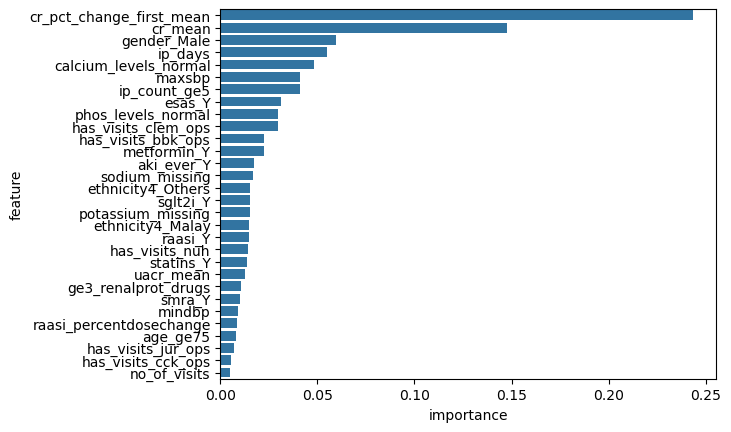

In [82]:
best_xgb_more = HalvingGridSearchCV(
        model_xgb,
        param_grid = params['gsp_xgb'],
        scoring='f1', #important to use f1 instead of default of accuracy given my imbalance
        cv=stratifiedCV,
        n_jobs=-1
        ).fit(x_train_more, y_train) #I already have class weights, so I think I don't want these in here b/c it will multiple them together per documentation

best_xgb_more_y_pred_train = best_xgb_more.predict(x_train_more)
print('Training f1: ',f1_score(y_train, best_xgb_more_y_pred_train, average=None)) #print both

best_xgb_more_y_pred = best_xgb_more.predict(x_test_more)
print('Testing f1: ',f1_score(y_test, best_xgb_more_y_pred, average=None))

#show which set of parameters were best in grid search: 
print(pd.DataFrame([best_xgb_more.best_params_]))

#create df of the feature importances 
data_tuples = []
data_tuples = list(zip(best_xgb_more.feature_names_in_,best_xgb_more.best_estimator_.feature_importances_))
best_xgb_more_varimport = pd.DataFrame(data_tuples, columns = ['feature', 'importance'])

#visualize
print(best_xgb_more_varimport.sort_values("importance", ascending=False).head(30))
sns.barplot(data=best_xgb_more_varimport.sort_values("importance", ascending=False).head(30), x="importance", y="feature")


In [83]:
print(classification_report(y_test, best_xgb_more_y_pred))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1288
           1       0.60      0.60      0.60        20

    accuracy                           0.99      1308
   macro avg       0.80      0.80      0.80      1308
weighted avg       0.99      0.99      0.99      1308



Confusion matrix:
[[1280    8]
 [   8   12]]


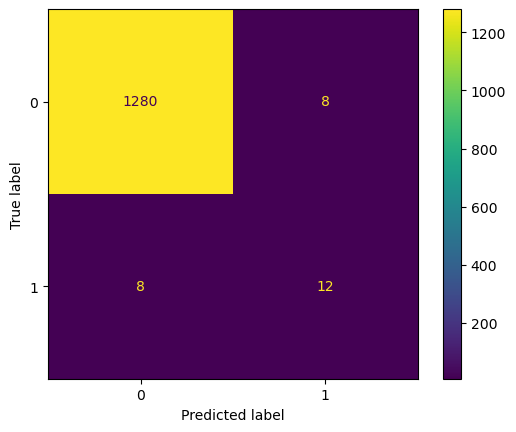

In [84]:
cm = confusion_matrix(y_test, best_xgb_more_y_pred)

print('Confusion matrix:')
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm
                              #,display_labels=clf.classes_
                             )
disp.plot()

plt.show()

In [85]:
#predict proba here 
best_xgb_more_y_prob = pd.DataFrame(best_xgb_more.predict_proba(x_test_more))

print('AUC: ',roc_auc_score(y_test, best_xgb_more_y_pred))

AUC:  0.7968944099378883


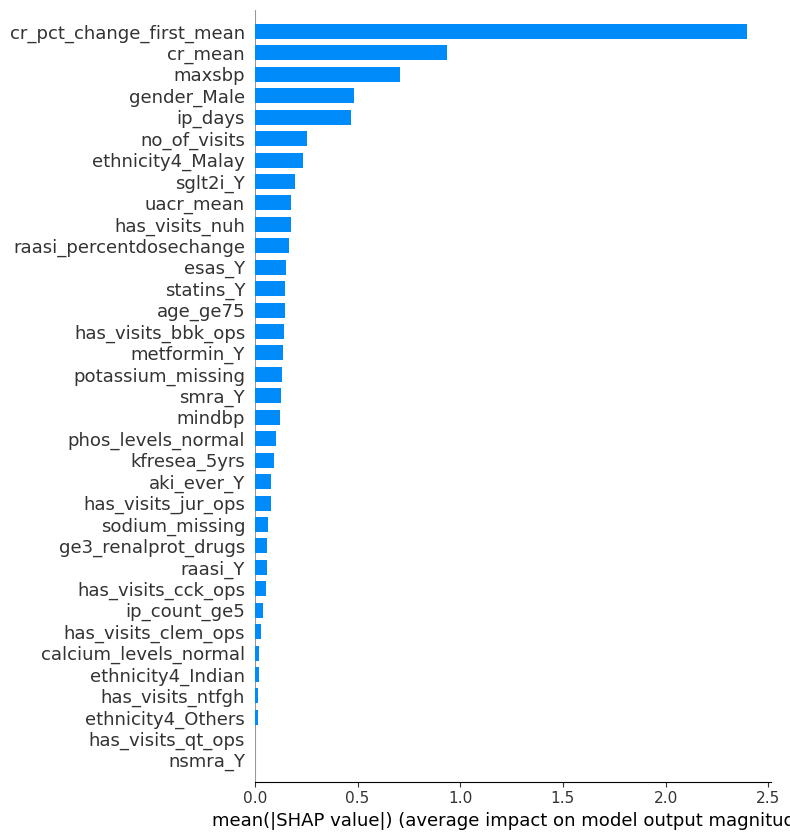

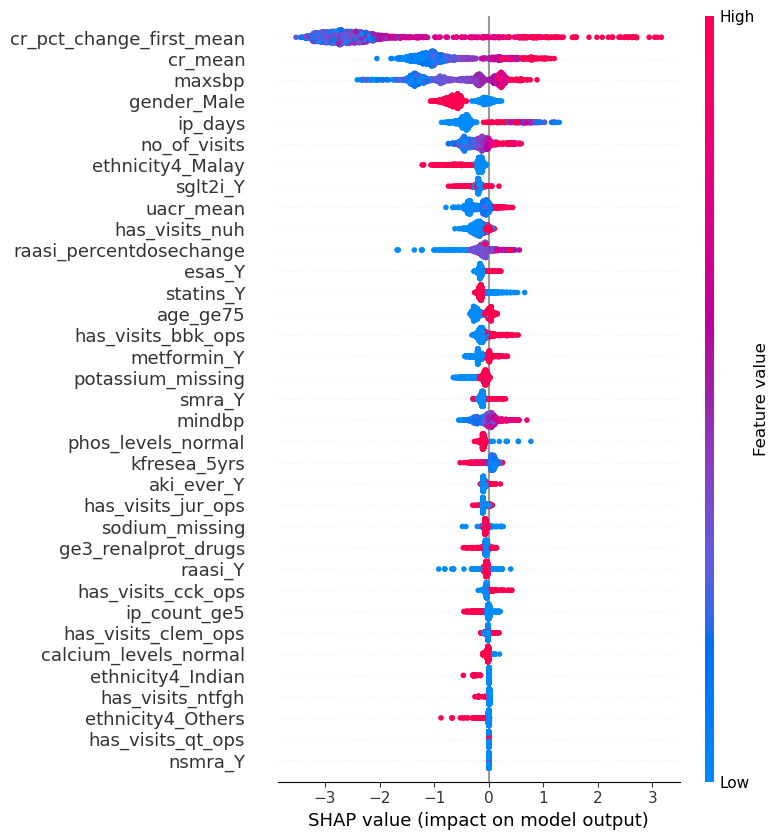

In [86]:
#SHAP for xgb more 
explainer = shap.TreeExplainer(best_xgb_more.best_estimator_) #have to use best estimator to grab the best model out of grid search
shap_values = explainer.shap_values(x_test_more) #use on test data 

shap.summary_plot(shap_values, x_test_more, plot_size=0.2, plot_type='bar', max_display = 50)
shap.summary_plot(shap_values, x_test_more, plot_size=0.2, max_display = 50)

In [87]:
'''#this isn't for both classes - just normal SHAP 
print(x_test_more.shape)
print(shap_values.shape)
print(shap_values)
'''

"#this isn't for both classes - just normal SHAP \nprint(x_test_more.shape)\nprint(shap_values.shape)\nprint(shap_values)\n"

##### XGBoost Less

Training f1:  [0.99858628 0.9985851 ]
Testing f1:  [0.99380325 0.52941176]
   colsample_bytree  lambda  learning_rate  max_depth  n_estimators  \
0              0.75       2           0.31          4            48   

   scale_pos_weight  subsample  
0               1.2        0.7  
                                    feature  importance
2                                   cr_mean    0.241793
0                  cr_pct_change_first_mean    0.175354
1                egfr_pct_change_first_mean    0.117413
11                              gender_Male    0.044209
5                                   ip_days    0.041463
12                             ip_count_ge5    0.034457
4                                    maxsbp    0.028055
27                                 stroke_Y    0.027015
18                        potassium_missing    0.022835
24                      ge3_renalprot_drugs    0.022535
3                                 egfr_mean    0.022092
13                                   maxdbp 

<Axes: xlabel='importance', ylabel='feature'>

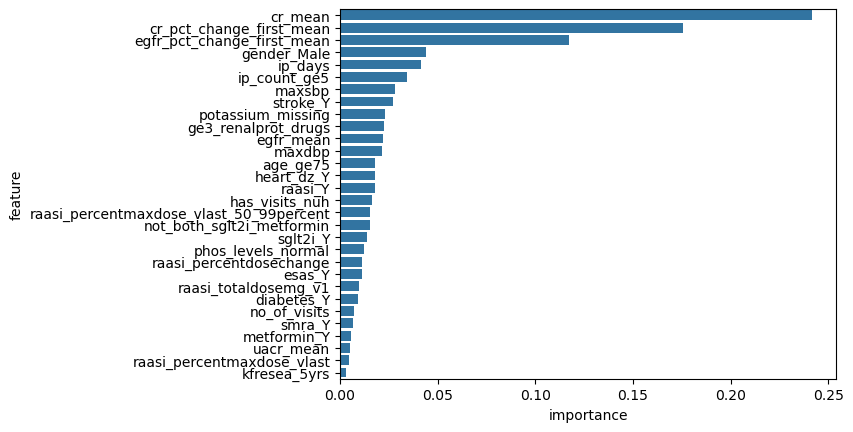

In [88]:
best_xgb_less = HalvingGridSearchCV(
        model_xgb,
        param_grid = params['gsp_xgb'],
        scoring='f1', #important to use f1 instead of default of accuracy given my imbalance
        cv=stratifiedCV,
        n_jobs=-1
        ).fit(x_train_less, y_train) #I already have class weights, so I think I don't want these in here b/c it will multiple them together per documentation

best_xgb_less_y_pred_train = best_xgb_less.predict(x_train_less)
print('Training f1: ',f1_score(y_train, best_xgb_less_y_pred_train, average=None)) #print both

best_xgb_less_y_pred = best_xgb_less.predict(x_test_less)
print('Testing f1: ',f1_score(y_test, best_xgb_less_y_pred, average=None))

#show which set of parameters were best in grid search: 
print(pd.DataFrame([best_xgb_less.best_params_]))

#create df of the feature importances 
data_tuples = []
data_tuples = list(zip(best_xgb_less.feature_names_in_,best_xgb_less.best_estimator_.feature_importances_))
best_xgb_less_varimport = pd.DataFrame(data_tuples, columns = ['feature', 'importance'])

#visualize
print(best_xgb_less_varimport.sort_values("importance", ascending=False).head(20))
sns.barplot(data=best_xgb_less_varimport.sort_values("importance", ascending=False).head(30), x="importance", y="feature")


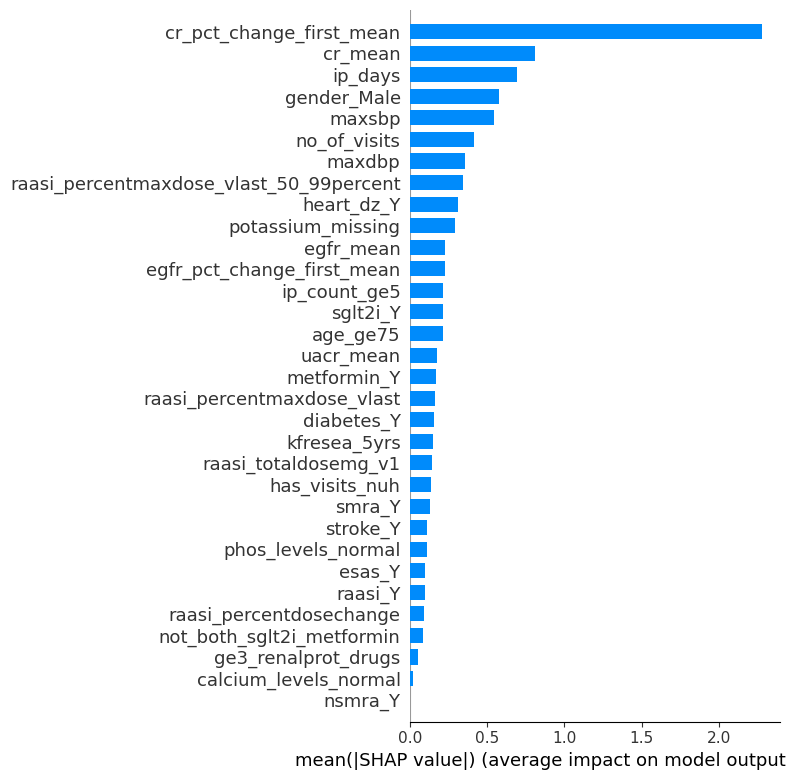

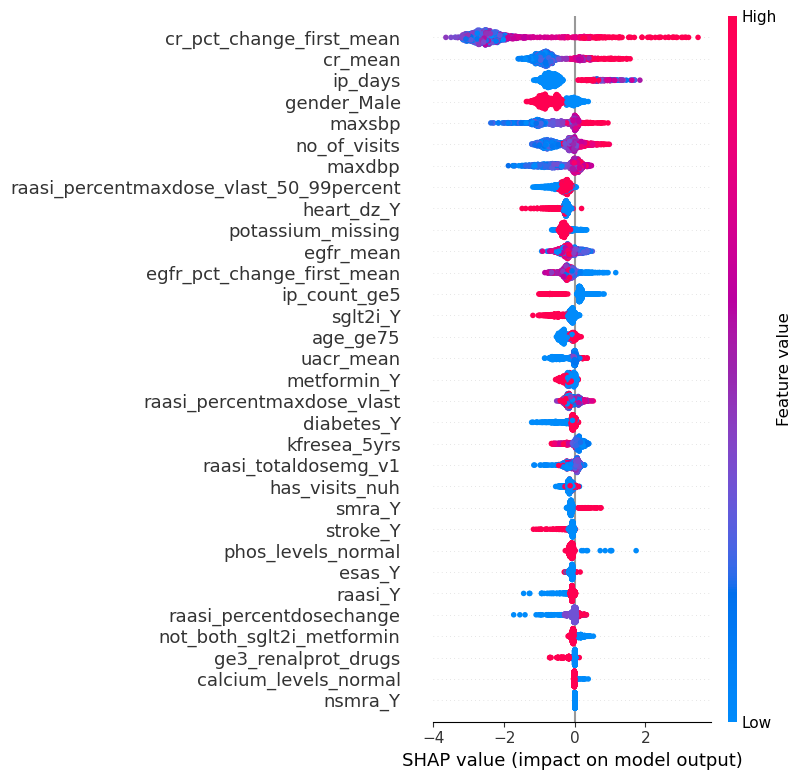

In [89]:
#SHAP for xgb less 
explainer = shap.TreeExplainer(best_xgb_less.best_estimator_) #have to use best estimator to grab the best model out of grid search
shap_values = explainer.shap_values(x_test_less) #use on test data 

shap.summary_plot(shap_values, x_test_less, plot_size=0.2, plot_type='bar', max_display = 50)
shap.summary_plot(shap_values, x_test_less, plot_size=0.2, max_display = 50)

In [91]:
print(classification_report(y_test, best_xgb_less_y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1288
           1       0.64      0.45      0.53        20

    accuracy                           0.99      1308
   macro avg       0.82      0.72      0.76      1308
weighted avg       0.99      0.99      0.99      1308



In [92]:
#predict proba here 
best_xgb_less_y_prob = pd.DataFrame(best_xgb_less.predict_proba(x_test_less))

print('AUC: ',roc_auc_score(y_test, best_xgb_less_y_pred))

AUC:  0.7230590062111801


Confusion matrix:
[[1283    5]
 [  11    9]]


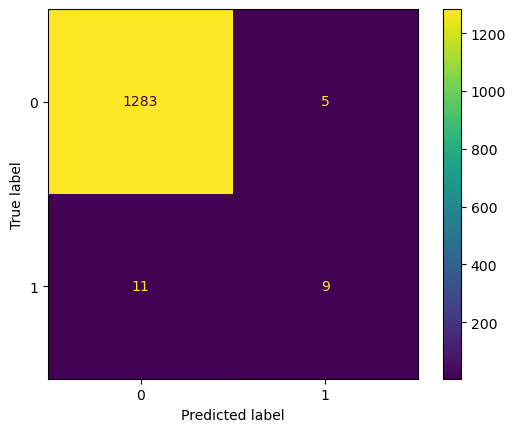

In [93]:
cm = confusion_matrix(y_test, best_xgb_less_y_pred)

print('Confusion matrix:')
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm
                              #,display_labels=clf.classes_
                             )
disp.plot()

plt.show()

<Axes: xlabel='raasi_percentdosechange', ylabel='Count'>

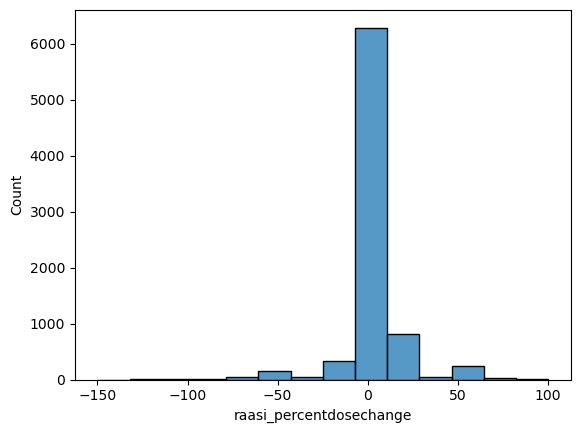

In [95]:
raw["raasi_percentdosechange"].describe()

sns.histplot(data=raw, x="raasi_percentdosechange", bins=14)

# Final test on 'external' validation data!

In [133]:
#already did normalization of validate above (but no smote or outlier removal) 
print(y_validate.shape)


#subset x to same columns as final model ('more' list)
x_validate_more = x_validate[x_train_more.columns]
print(x_validate_more.shape)
print(x_validate_more.head())

#confirm same order
#print(x_validate_more.columns)
#print(x_train_more.columns)

(1309,)
<bound method IndexOpsMixin.value_counts of 1350     0
19847    0
23053    0
15247    0
1656     0
        ..
26797    0
7187     0
15192    0
20198    0
1850     0
Name: aki_proxy, Length: 1309, dtype: int64>
(1309, 35)
       sodium_missing  cr_pct_change_first_mean  ethnicity4_Indian  \
1350              1.0                 -0.888690                1.0   
19847             1.0                 -0.304146                0.0   
23053             1.0                  0.611021                0.0   
15247             1.0                  0.855902                0.0   
1656              1.0                 -0.068716                0.0   

       gender_Male  statins_Y  ge3_renalprot_drugs   cr_mean  ip_count_ge5  \
1350           0.0        1.0                  1.0 -0.601759           0.0   
19847          1.0        1.0                  1.0 -0.415247           1.0   
23053          1.0        1.0                  0.0 -0.228734           0.0   
15247          1.0        1.0         

In [118]:
validate_score = best_xgb_more.score(x_validate_more, y_validate)
validate_feat_import = best_xgb_more.best_estimator_.feature_importances_

#get predicted probabilities (decimal) 
x_prob_validate = pd.DataFrame(best_xgb_more.predict_proba(x_validate_more))
#print(x_prob_validate.head())

#actual predicting class (1,0)
y_validate_predict = best_xgb_more.predict(x_validate_more)
#print(y_validate_predict)

#scores
print('accuracy', validate_score)
#print('f1',best_xgb_more.best_score_)
print('Validate f1: ',f1_score(y_validate, y_validate_predict, average=None))
print('AUC: ',roc_auc_score(y_validate, y_validate_predict))

accuracy 0.5714285714285714
Validate f1:  [0.99301242 0.57142857]
AUC:  0.78222049689441


In [116]:
print(classification_report(y_validate, y_validate_predict))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1288
           1       0.57      0.57      0.57        21

    accuracy                           0.99      1309
   macro avg       0.78      0.78      0.78      1309
weighted avg       0.99      0.99      0.99      1309



In [115]:
#actual result vs predicted class - same table as below, just looks a bit nicer 
pd.crosstab(y_validate,y_validate_predict)

col_0         0   1
aki_proxy          
0          1279   9
1             9  12

Confusion matrix:
[[1279    9]
 [   9   12]]


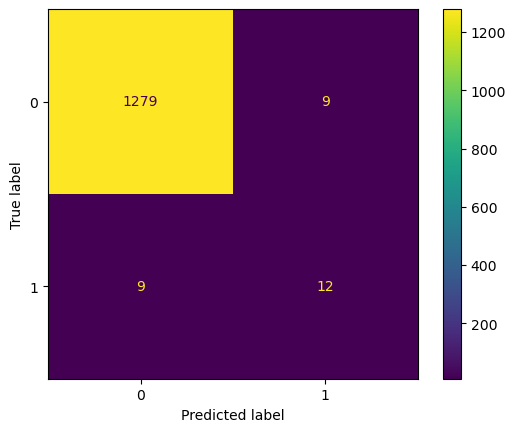

In [117]:
cm = confusion_matrix(y_validate, y_validate_predict)

print('Confusion matrix:')
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm
                              #,display_labels=clf.classes_
                             )
disp.plot()

plt.show()


In [121]:
# From sph
# Plotly plotting package
import plotly.graph_objects as go
import plotly.express as px

y_pred = x_prob_validate #predicted probabilities I'm already calcing. code subsets to only probability for 1 below 
y_df_test = y_validate

yroc = np.array([1, 1, 2, 2])

fpr, tpr, _  = roc_curve(y_df_test,y_pred.iloc[:,1].values)


roc_df = pd.DataFrame(
    {
        'False Positive Rate':fpr,
        'True Positive Rate':tpr

    }
)

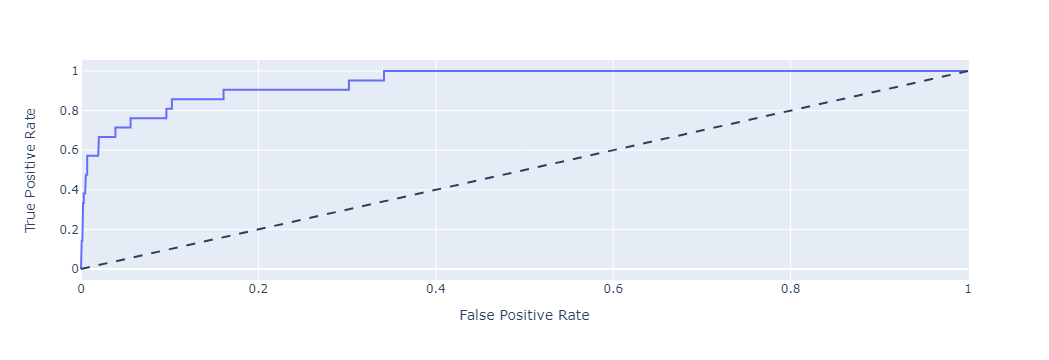

In [122]:
# Visualize ROC curve
fig = px.line(roc_df,y='True Positive Rate',x='False Positive Rate') #facet_col='method',color='method'

#I added the line for random guess 
fig.add_shape(type="line",
              x0=0, 
              y0=0, 
              x1=1, 
              y1=1,
             line_dash='dash')

fig